# ML for Bioinformatics
## HW6 - Variational Autoencoder

---

Name: Alireza Akbari

Student No.: 95105379

---
do not forget to insert your Name and Student No. in this cell !!!!

#import library and setting device

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.auto import tqdm, trange
%matplotlib inline

In [2]:
device = None
######################## P0 ########################## 
# check if gpu is available then put device to cuda0 #
# else device is equal to cpu                        #
######################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
######################## end #########################

cuda:0


#loading Data
The MNIST database of handwritten digits contain diffrents images of digits. 

similar to MNIST,fashionMNIST is dataset containg 10 type of clothes instead of 10 type of digits. 

for example label 0 in MNIST is for 0 digit and 0 in FashionMNIST is for T-shirt. all the images is gray-scale and 28*28.

for more information you can visit this [link](https://github.com/zalandoresearch/fashion-mnist) 

In [3]:
# Get MNIST dataloader
BATCH_SIZE = 128
data_loader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 4,
}
train_dataset = None
test_dataset = None
train_loader = None
test_loader = None
############################## P1 ##############################
# in this cell first download the fashionMNIST dataset         #
# for train (use toTensor transform and download = True)       #
# and put it in train_dataset. then get test dataset          #
# and put it in test_dataset(no need to download again).       #
# then make train and test loader using the data_loader_kwargs #
################################################################
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, **data_loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)

######################## end #########################


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


#Auto-Encoder

In [4]:
class AE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(AE, self).__init__()
        # input_dim = is the dimension of your input
        # encoder_dims = is list containing of some integer that shows the dimension of encoder layers, between input layer and latent layer  
        # z_dim = dimension of latent layer
        # decoder_dims = is list containing of some integer that shows the dimension of decoder layers, between latent layer and output layer (same as input_dim)  
        self.type_str = 'AE'
        self.z_dim = z_dim
        self.dropout = nn.Dropout(p=0.2)
        encoder_layers = list()
        ####################### P2 ###############################
        # Iterate over `encoder_dims` and create fully connected #
        # layers using nn.Linear. Use ReLU activation function   #   
        # after each FC layer using nn.ReLU Append all layers to #
        #`encoder_layers`.                                       #
        ##########################################################
        encoder_layers += [nn.Linear(input_dim, encoder_dims[0]), nn.ReLU()]
        for dim_index in range(1, len(encoder_dims)):
          encoder_layers += [nn.Linear(encoder_dims[dim_index-1], encoder_dims[dim_index]), nn.ReLU()]
        ####################### End ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Compute Z
        self.z_layer = None
        ########################  P3 #############################
        # Define a fully connected layer that maps the output of #
        # previous part to `z_dim` dimensions, store it in       #
        # `self.z_layer`. No activation function is needed after #
        # this layer.                                            #
        ##########################################################
        self.z_layer = nn.Linear(encoder_dims[-1], z_dim)
        ######################## End #############################

        # Decoder part
        decoder_layers = list()
        ########################## P4 ###############################
        # Define the decoder part (Use `decoder_dims`)              #
        # Use ReLU activation function after each FC layer          # 
        # (except the last one).The last layer output should be     #
        # of `input_dim` size. Append all layers to `decoder_layers`#
        #############################################################
        decoder_layers += [nn.Linear(z_dim, decoder_dims[0]), nn.ReLU()]
        for dim_index in range(1, len(decoder_dims)):
          decoder_layers += [nn.Linear(decoder_dims[dim_index-1], decoder_dims[dim_index]), nn.ReLU()]
        decoder_layers += [nn.Linear(decoder_dims[-1], input_dim), nn.ReLU()]
        ####################### End ##################################
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x_hat, z = None, None
        dropped_out = self.dropout(x)
        ################ P5 #######################
        # Do the forward pass                     #
        # use dropped_out instead of x            #
        # Compute `x_hat` (reconstructed inputs), #
        # and `z` (the latent variables)          #
        ###########################################
        z = self.z_layer(self.encoder(dropped_out))
        x_hat = self.decoder(z)
        ####################### End ###############
        return x_hat, z, None 

    def get_loss(self, x, x_hat, *_):
        ########### P6 ############
        # Compute and return the  #
        # MSE between x and x_hat #
        ###########################  
        return F.mse_loss(x, x_hat)
        ########### End ###########


# train and test functions
in the following cells we enumerate on datasets and on each batch, first we flatten 28*28 image to 784 and then giving this to forward pass of our model. then by computing loss and running backprop on loss we can have all the gradients. then by calling optimizer.step() we update all the parameters.
in test function we find loss and report that.


In [5]:
LOG_INTERVAL = 10
def train(model, optimizer, verbose=True):
    """
    This function trains a `model` on `train_loader` for 1 epoch and prints the
    loss value
    """
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(tqdm(train_loader, desc='Batches', leave=False)):
        x = x.flatten(start_dim=1).to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = model.get_loss(x, x_hat, mu, logvar)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % LOG_INTERVAL == LOG_INTERVAL-1:
            print('    Train [%d/%d]\t | \tLoss: %.5f' % (batch_idx * x.shape[0], len(train_loader.dataset), loss.item() / x.shape[0]))
    train_loss /= len(train_loader.dataset)
    if verbose:
        print('==> Train | Average loss: %.4f' % train_loss)

In [6]:
def test(model, verbose=True):
    """
    This function tests a `model` on a `test_loader` and prints the loss value
    """
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.flatten(start_dim=1).to(device)
            x_hat, mu, logvar = model(x)
            loss = model.get_loss(x, x_hat, mu, logvar)
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('==> Test  | Average loss: %.4f' % test_loss)

In [7]:
def run(model, n_epoch, verbose=True):
    """
    This function will optimize parameters of `model` for `n_epoch` epochs
    on `train_loader` and validate it on `test_loader`.
    """
    LEARNING_RATE = 5e-5
    ###################### P7 ################################
    # Send `model` to the desired device, defined in `device`#
    ##########################################################
    model = model.to(device)
    ####################### End ##############################

    optimizer = None
    ################## P8 #####################
    # Initialize a new Adam optimizer         #
    ###########################################
    optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
    ################## End ####################

    for epoch in trange(1, n_epoch+1, desc='Epochs', leave=True):
        if verbose:
            print('\nEpoch %d:' % epoch)
        train(model, optimizer, verbose)
        test(model, verbose)

In [8]:
#run this cell to train model and report loss on test dataset
ae = AE(28*28, [512,128,64], 30, [64,128,512])
run(ae,40)


Epoch 1:


    Train [1152/60000]	 | 	Loss: 0.00146
    Train [2432/60000]	 | 	Loss: 0.00140
    Train [3712/60000]	 | 	Loss: 0.00145
    Train [4992/60000]	 | 	Loss: 0.00144
    Train [6272/60000]	 | 	Loss: 0.00133
    Train [7552/60000]	 | 	Loss: 0.00110
    Train [8832/60000]	 | 	Loss: 0.00099
    Train [10112/60000]	 | 	Loss: 0.00093
    Train [11392/60000]	 | 	Loss: 0.00083
    Train [12672/60000]	 | 	Loss: 0.00083
    Train [13952/60000]	 | 	Loss: 0.00082
    Train [15232/60000]	 | 	Loss: 0.00081
    Train [16512/60000]	 | 	Loss: 0.00083
    Train [17792/60000]	 | 	Loss: 0.00075
    Train [19072/60000]	 | 	Loss: 0.00079
    Train [20352/60000]	 | 	Loss: 0.00076
    Train [21632/60000]	 | 	Loss: 0.00083
    Train [22912/60000]	 | 	Loss: 0.00076
    Train [24192/60000]	 | 	Loss: 0.00077
    Train [25472/60000]	 | 	Loss: 0.00075
    Train [26752/60000]	 | 	Loss: 0.00076
    Train [28032/60000]	 | 	Loss: 0.00078
    Train [29312/60000]	 | 	Loss: 0.00077
    Train [30592/60000]	 | 	Loss: 0.00076

    Train [1152/60000]	 | 	Loss: 0.00055
    Train [2432/60000]	 | 	Loss: 0.00054
    Train [3712/60000]	 | 	Loss: 0.00052
    Train [4992/60000]	 | 	Loss: 0.00057
    Train [6272/60000]	 | 	Loss: 0.00054
    Train [7552/60000]	 | 	Loss: 0.00052
    Train [8832/60000]	 | 	Loss: 0.00050
    Train [10112/60000]	 | 	Loss: 0.00050
    Train [11392/60000]	 | 	Loss: 0.00053
    Train [12672/60000]	 | 	Loss: 0.00049
    Train [13952/60000]	 | 	Loss: 0.00050
    Train [15232/60000]	 | 	Loss: 0.00054
    Train [16512/60000]	 | 	Loss: 0.00049
    Train [17792/60000]	 | 	Loss: 0.00053
    Train [19072/60000]	 | 	Loss: 0.00046
    Train [20352/60000]	 | 	Loss: 0.00051
    Train [21632/60000]	 | 	Loss: 0.00043
    Train [22912/60000]	 | 	Loss: 0.00049
    Train [24192/60000]	 | 	Loss: 0.00048
    Train [25472/60000]	 | 	Loss: 0.00048
    Train [26752/60000]	 | 	Loss: 0.00046
    Train [28032/60000]	 | 	Loss: 0.00044
    Train [29312/60000]	 | 	Loss: 0.00043
    Train [30592/60000]	 | 	Loss: 0.00047

    Train [1152/60000]	 | 	Loss: 0.00040
    Train [2432/60000]	 | 	Loss: 0.00039
    Train [3712/60000]	 | 	Loss: 0.00042
    Train [4992/60000]	 | 	Loss: 0.00041
    Train [6272/60000]	 | 	Loss: 0.00039
    Train [7552/60000]	 | 	Loss: 0.00042
    Train [8832/60000]	 | 	Loss: 0.00039
    Train [10112/60000]	 | 	Loss: 0.00039
    Train [11392/60000]	 | 	Loss: 0.00040
    Train [12672/60000]	 | 	Loss: 0.00039
    Train [13952/60000]	 | 	Loss: 0.00038
    Train [15232/60000]	 | 	Loss: 0.00039
    Train [16512/60000]	 | 	Loss: 0.00038
    Train [17792/60000]	 | 	Loss: 0.00036
    Train [19072/60000]	 | 	Loss: 0.00037
    Train [20352/60000]	 | 	Loss: 0.00038
    Train [21632/60000]	 | 	Loss: 0.00037
    Train [22912/60000]	 | 	Loss: 0.00036
    Train [24192/60000]	 | 	Loss: 0.00035
    Train [25472/60000]	 | 	Loss: 0.00034
    Train [26752/60000]	 | 	Loss: 0.00034
    Train [28032/60000]	 | 	Loss: 0.00037
    Train [29312/60000]	 | 	Loss: 0.00035
    Train [30592/60000]	 | 	Loss: 0.00037

    Train [1152/60000]	 | 	Loss: 0.00031
    Train [2432/60000]	 | 	Loss: 0.00035
    Train [3712/60000]	 | 	Loss: 0.00032
    Train [4992/60000]	 | 	Loss: 0.00034
    Train [6272/60000]	 | 	Loss: 0.00032
    Train [7552/60000]	 | 	Loss: 0.00032
    Train [8832/60000]	 | 	Loss: 0.00033
    Train [10112/60000]	 | 	Loss: 0.00035
    Train [11392/60000]	 | 	Loss: 0.00034
    Train [12672/60000]	 | 	Loss: 0.00031
    Train [13952/60000]	 | 	Loss: 0.00032
    Train [15232/60000]	 | 	Loss: 0.00032
    Train [16512/60000]	 | 	Loss: 0.00034
    Train [17792/60000]	 | 	Loss: 0.00033
    Train [19072/60000]	 | 	Loss: 0.00033
    Train [20352/60000]	 | 	Loss: 0.00031
    Train [21632/60000]	 | 	Loss: 0.00033
    Train [22912/60000]	 | 	Loss: 0.00032
    Train [24192/60000]	 | 	Loss: 0.00031
    Train [25472/60000]	 | 	Loss: 0.00032
    Train [26752/60000]	 | 	Loss: 0.00028
    Train [28032/60000]	 | 	Loss: 0.00033
    Train [29312/60000]	 | 	Loss: 0.00033
    Train [30592/60000]	 | 	Loss: 0.00033

    Train [1152/60000]	 | 	Loss: 0.00032
    Train [2432/60000]	 | 	Loss: 0.00030
    Train [3712/60000]	 | 	Loss: 0.00031
    Train [4992/60000]	 | 	Loss: 0.00033
    Train [6272/60000]	 | 	Loss: 0.00031
    Train [7552/60000]	 | 	Loss: 0.00031
    Train [8832/60000]	 | 	Loss: 0.00032
    Train [10112/60000]	 | 	Loss: 0.00030
    Train [11392/60000]	 | 	Loss: 0.00031
    Train [12672/60000]	 | 	Loss: 0.00029
    Train [13952/60000]	 | 	Loss: 0.00030
    Train [15232/60000]	 | 	Loss: 0.00030
    Train [16512/60000]	 | 	Loss: 0.00031
    Train [17792/60000]	 | 	Loss: 0.00029
    Train [19072/60000]	 | 	Loss: 0.00032
    Train [20352/60000]	 | 	Loss: 0.00032
    Train [21632/60000]	 | 	Loss: 0.00031
    Train [22912/60000]	 | 	Loss: 0.00032
    Train [24192/60000]	 | 	Loss: 0.00031
    Train [25472/60000]	 | 	Loss: 0.00032
    Train [26752/60000]	 | 	Loss: 0.00030
    Train [28032/60000]	 | 	Loss: 0.00028
    Train [29312/60000]	 | 	Loss: 0.00032
    Train [30592/60000]	 | 	Loss: 0.00032

    Train [1152/60000]	 | 	Loss: 0.00031
    Train [2432/60000]	 | 	Loss: 0.00029
    Train [3712/60000]	 | 	Loss: 0.00031
    Train [4992/60000]	 | 	Loss: 0.00028
    Train [6272/60000]	 | 	Loss: 0.00030
    Train [7552/60000]	 | 	Loss: 0.00029
    Train [8832/60000]	 | 	Loss: 0.00031
    Train [10112/60000]	 | 	Loss: 0.00030
    Train [11392/60000]	 | 	Loss: 0.00028
    Train [12672/60000]	 | 	Loss: 0.00031
    Train [13952/60000]	 | 	Loss: 0.00030
    Train [15232/60000]	 | 	Loss: 0.00030
    Train [16512/60000]	 | 	Loss: 0.00030
    Train [17792/60000]	 | 	Loss: 0.00030
    Train [19072/60000]	 | 	Loss: 0.00031
    Train [20352/60000]	 | 	Loss: 0.00029
    Train [21632/60000]	 | 	Loss: 0.00030
    Train [22912/60000]	 | 	Loss: 0.00031
    Train [24192/60000]	 | 	Loss: 0.00030
    Train [25472/60000]	 | 	Loss: 0.00030
    Train [26752/60000]	 | 	Loss: 0.00030
    Train [28032/60000]	 | 	Loss: 0.00028
    Train [29312/60000]	 | 	Loss: 0.00032
    Train [30592/60000]	 | 	Loss: 0.00029

    Train [1152/60000]	 | 	Loss: 0.00028
    Train [2432/60000]	 | 	Loss: 0.00030
    Train [3712/60000]	 | 	Loss: 0.00031
    Train [4992/60000]	 | 	Loss: 0.00030
    Train [6272/60000]	 | 	Loss: 0.00031
    Train [7552/60000]	 | 	Loss: 0.00028
    Train [8832/60000]	 | 	Loss: 0.00030
    Train [10112/60000]	 | 	Loss: 0.00029
    Train [11392/60000]	 | 	Loss: 0.00029
    Train [12672/60000]	 | 	Loss: 0.00029
    Train [13952/60000]	 | 	Loss: 0.00029
    Train [15232/60000]	 | 	Loss: 0.00029
    Train [16512/60000]	 | 	Loss: 0.00029
    Train [17792/60000]	 | 	Loss: 0.00029
    Train [19072/60000]	 | 	Loss: 0.00031
    Train [20352/60000]	 | 	Loss: 0.00030
    Train [21632/60000]	 | 	Loss: 0.00028
    Train [22912/60000]	 | 	Loss: 0.00029
    Train [24192/60000]	 | 	Loss: 0.00032
    Train [25472/60000]	 | 	Loss: 0.00029
    Train [26752/60000]	 | 	Loss: 0.00029
    Train [28032/60000]	 | 	Loss: 0.00028
    Train [29312/60000]	 | 	Loss: 0.00028
    Train [30592/60000]	 | 	Loss: 0.00029

    Train [1152/60000]	 | 	Loss: 0.00029
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00027
    Train [4992/60000]	 | 	Loss: 0.00028
    Train [6272/60000]	 | 	Loss: 0.00028
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00027
    Train [10112/60000]	 | 	Loss: 0.00029
    Train [11392/60000]	 | 	Loss: 0.00029
    Train [12672/60000]	 | 	Loss: 0.00029
    Train [13952/60000]	 | 	Loss: 0.00028
    Train [15232/60000]	 | 	Loss: 0.00030
    Train [16512/60000]	 | 	Loss: 0.00028
    Train [17792/60000]	 | 	Loss: 0.00031
    Train [19072/60000]	 | 	Loss: 0.00030
    Train [20352/60000]	 | 	Loss: 0.00028
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00029
    Train [25472/60000]	 | 	Loss: 0.00028
    Train [26752/60000]	 | 	Loss: 0.00029
    Train [28032/60000]	 | 	Loss: 0.00031
    Train [29312/60000]	 | 	Loss: 0.00029
    Train [30592/60000]	 | 	Loss: 0.00030

    Train [1152/60000]	 | 	Loss: 0.00028
    Train [2432/60000]	 | 	Loss: 0.00029
    Train [3712/60000]	 | 	Loss: 0.00028
    Train [4992/60000]	 | 	Loss: 0.00031
    Train [6272/60000]	 | 	Loss: 0.00027
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00029
    Train [10112/60000]	 | 	Loss: 0.00027
    Train [11392/60000]	 | 	Loss: 0.00030
    Train [12672/60000]	 | 	Loss: 0.00028
    Train [13952/60000]	 | 	Loss: 0.00028
    Train [15232/60000]	 | 	Loss: 0.00027
    Train [16512/60000]	 | 	Loss: 0.00028
    Train [17792/60000]	 | 	Loss: 0.00027
    Train [19072/60000]	 | 	Loss: 0.00030
    Train [20352/60000]	 | 	Loss: 0.00028
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00030
    Train [24192/60000]	 | 	Loss: 0.00030
    Train [25472/60000]	 | 	Loss: 0.00031
    Train [26752/60000]	 | 	Loss: 0.00027
    Train [28032/60000]	 | 	Loss: 0.00029
    Train [29312/60000]	 | 	Loss: 0.00028
    Train [30592/60000]	 | 	Loss: 0.00027

    Train [1152/60000]	 | 	Loss: 0.00028
    Train [2432/60000]	 | 	Loss: 0.00031
    Train [3712/60000]	 | 	Loss: 0.00030
    Train [4992/60000]	 | 	Loss: 0.00028
    Train [6272/60000]	 | 	Loss: 0.00028
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00028
    Train [10112/60000]	 | 	Loss: 0.00028
    Train [11392/60000]	 | 	Loss: 0.00028
    Train [12672/60000]	 | 	Loss: 0.00028
    Train [13952/60000]	 | 	Loss: 0.00026
    Train [15232/60000]	 | 	Loss: 0.00028
    Train [16512/60000]	 | 	Loss: 0.00027
    Train [17792/60000]	 | 	Loss: 0.00027
    Train [19072/60000]	 | 	Loss: 0.00026
    Train [20352/60000]	 | 	Loss: 0.00026
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00026
    Train [25472/60000]	 | 	Loss: 0.00026
    Train [26752/60000]	 | 	Loss: 0.00028
    Train [28032/60000]	 | 	Loss: 0.00028
    Train [29312/60000]	 | 	Loss: 0.00028
    Train [30592/60000]	 | 	Loss: 0.00027

    Train [1152/60000]	 | 	Loss: 0.00027
    Train [2432/60000]	 | 	Loss: 0.00026
    Train [3712/60000]	 | 	Loss: 0.00028
    Train [4992/60000]	 | 	Loss: 0.00027
    Train [6272/60000]	 | 	Loss: 0.00029
    Train [7552/60000]	 | 	Loss: 0.00028
    Train [8832/60000]	 | 	Loss: 0.00026
    Train [10112/60000]	 | 	Loss: 0.00027
    Train [11392/60000]	 | 	Loss: 0.00026
    Train [12672/60000]	 | 	Loss: 0.00027
    Train [13952/60000]	 | 	Loss: 0.00027
    Train [15232/60000]	 | 	Loss: 0.00027
    Train [16512/60000]	 | 	Loss: 0.00026
    Train [17792/60000]	 | 	Loss: 0.00028
    Train [19072/60000]	 | 	Loss: 0.00030
    Train [20352/60000]	 | 	Loss: 0.00027
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00027
    Train [25472/60000]	 | 	Loss: 0.00028
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00027
    Train [29312/60000]	 | 	Loss: 0.00028
    Train [30592/60000]	 | 	Loss: 0.00026

    Train [1152/60000]	 | 	Loss: 0.00024
    Train [2432/60000]	 | 	Loss: 0.00026
    Train [3712/60000]	 | 	Loss: 0.00029
    Train [4992/60000]	 | 	Loss: 0.00025
    Train [6272/60000]	 | 	Loss: 0.00028
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00025
    Train [10112/60000]	 | 	Loss: 0.00026
    Train [11392/60000]	 | 	Loss: 0.00029
    Train [12672/60000]	 | 	Loss: 0.00025
    Train [13952/60000]	 | 	Loss: 0.00026
    Train [15232/60000]	 | 	Loss: 0.00023
    Train [16512/60000]	 | 	Loss: 0.00028
    Train [17792/60000]	 | 	Loss: 0.00027
    Train [19072/60000]	 | 	Loss: 0.00027
    Train [20352/60000]	 | 	Loss: 0.00024
    Train [21632/60000]	 | 	Loss: 0.00025
    Train [22912/60000]	 | 	Loss: 0.00024
    Train [24192/60000]	 | 	Loss: 0.00026
    Train [25472/60000]	 | 	Loss: 0.00026
    Train [26752/60000]	 | 	Loss: 0.00024
    Train [28032/60000]	 | 	Loss: 0.00028
    Train [29312/60000]	 | 	Loss: 0.00024
    Train [30592/60000]	 | 	Loss: 0.00027

    Train [1152/60000]	 | 	Loss: 0.00027
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00025
    Train [4992/60000]	 | 	Loss: 0.00024
    Train [6272/60000]	 | 	Loss: 0.00025
    Train [7552/60000]	 | 	Loss: 0.00025
    Train [8832/60000]	 | 	Loss: 0.00027
    Train [10112/60000]	 | 	Loss: 0.00026
    Train [11392/60000]	 | 	Loss: 0.00026
    Train [12672/60000]	 | 	Loss: 0.00026
    Train [13952/60000]	 | 	Loss: 0.00025
    Train [15232/60000]	 | 	Loss: 0.00027
    Train [16512/60000]	 | 	Loss: 0.00024
    Train [17792/60000]	 | 	Loss: 0.00026
    Train [19072/60000]	 | 	Loss: 0.00024
    Train [20352/60000]	 | 	Loss: 0.00026
    Train [21632/60000]	 | 	Loss: 0.00024
    Train [22912/60000]	 | 	Loss: 0.00026
    Train [24192/60000]	 | 	Loss: 0.00026
    Train [25472/60000]	 | 	Loss: 0.00026
    Train [26752/60000]	 | 	Loss: 0.00025
    Train [28032/60000]	 | 	Loss: 0.00025
    Train [29312/60000]	 | 	Loss: 0.00025
    Train [30592/60000]	 | 	Loss: 0.00027

    Train [1152/60000]	 | 	Loss: 0.00027
    Train [2432/60000]	 | 	Loss: 0.00025
    Train [3712/60000]	 | 	Loss: 0.00026
    Train [4992/60000]	 | 	Loss: 0.00025
    Train [6272/60000]	 | 	Loss: 0.00026
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00025
    Train [10112/60000]	 | 	Loss: 0.00024
    Train [11392/60000]	 | 	Loss: 0.00026
    Train [12672/60000]	 | 	Loss: 0.00026
    Train [13952/60000]	 | 	Loss: 0.00026
    Train [15232/60000]	 | 	Loss: 0.00025
    Train [16512/60000]	 | 	Loss: 0.00026
    Train [17792/60000]	 | 	Loss: 0.00026
    Train [19072/60000]	 | 	Loss: 0.00026
    Train [20352/60000]	 | 	Loss: 0.00024
    Train [21632/60000]	 | 	Loss: 0.00026
    Train [22912/60000]	 | 	Loss: 0.00023
    Train [24192/60000]	 | 	Loss: 0.00025
    Train [25472/60000]	 | 	Loss: 0.00026
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00024
    Train [29312/60000]	 | 	Loss: 0.00026
    Train [30592/60000]	 | 	Loss: 0.00026

    Train [1152/60000]	 | 	Loss: 0.00025
    Train [2432/60000]	 | 	Loss: 0.00026
    Train [3712/60000]	 | 	Loss: 0.00025
    Train [4992/60000]	 | 	Loss: 0.00025
    Train [6272/60000]	 | 	Loss: 0.00026
    Train [7552/60000]	 | 	Loss: 0.00026
    Train [8832/60000]	 | 	Loss: 0.00026
    Train [10112/60000]	 | 	Loss: 0.00025
    Train [11392/60000]	 | 	Loss: 0.00023
    Train [12672/60000]	 | 	Loss: 0.00025
    Train [13952/60000]	 | 	Loss: 0.00025
    Train [15232/60000]	 | 	Loss: 0.00026
    Train [16512/60000]	 | 	Loss: 0.00024
    Train [17792/60000]	 | 	Loss: 0.00027
    Train [19072/60000]	 | 	Loss: 0.00025
    Train [20352/60000]	 | 	Loss: 0.00024
    Train [21632/60000]	 | 	Loss: 0.00026
    Train [22912/60000]	 | 	Loss: 0.00025
    Train [24192/60000]	 | 	Loss: 0.00027
    Train [25472/60000]	 | 	Loss: 0.00024
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00025
    Train [29312/60000]	 | 	Loss: 0.00025
    Train [30592/60000]	 | 	Loss: 0.00025

    Train [1152/60000]	 | 	Loss: 0.00024
    Train [2432/60000]	 | 	Loss: 0.00026
    Train [3712/60000]	 | 	Loss: 0.00025
    Train [4992/60000]	 | 	Loss: 0.00025
    Train [6272/60000]	 | 	Loss: 0.00025
    Train [7552/60000]	 | 	Loss: 0.00024
    Train [8832/60000]	 | 	Loss: 0.00024
    Train [10112/60000]	 | 	Loss: 0.00025
    Train [11392/60000]	 | 	Loss: 0.00026
    Train [12672/60000]	 | 	Loss: 0.00025
    Train [13952/60000]	 | 	Loss: 0.00024
    Train [15232/60000]	 | 	Loss: 0.00026
    Train [16512/60000]	 | 	Loss: 0.00025
    Train [17792/60000]	 | 	Loss: 0.00028
    Train [19072/60000]	 | 	Loss: 0.00027
    Train [20352/60000]	 | 	Loss: 0.00024
    Train [21632/60000]	 | 	Loss: 0.00026
    Train [22912/60000]	 | 	Loss: 0.00026
    Train [24192/60000]	 | 	Loss: 0.00025
    Train [25472/60000]	 | 	Loss: 0.00025
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00024
    Train [29312/60000]	 | 	Loss: 0.00026
    Train [30592/60000]	 | 	Loss: 0.00025

    Train [1152/60000]	 | 	Loss: 0.00025
    Train [2432/60000]	 | 	Loss: 0.00024
    Train [3712/60000]	 | 	Loss: 0.00025
    Train [4992/60000]	 | 	Loss: 0.00023
    Train [6272/60000]	 | 	Loss: 0.00025
    Train [7552/60000]	 | 	Loss: 0.00024
    Train [8832/60000]	 | 	Loss: 0.00026
    Train [10112/60000]	 | 	Loss: 0.00022
    Train [11392/60000]	 | 	Loss: 0.00025
    Train [12672/60000]	 | 	Loss: 0.00024
    Train [13952/60000]	 | 	Loss: 0.00025
    Train [15232/60000]	 | 	Loss: 0.00025
    Train [16512/60000]	 | 	Loss: 0.00023
    Train [17792/60000]	 | 	Loss: 0.00026
    Train [19072/60000]	 | 	Loss: 0.00024
    Train [20352/60000]	 | 	Loss: 0.00026
    Train [21632/60000]	 | 	Loss: 0.00023
    Train [22912/60000]	 | 	Loss: 0.00024
    Train [24192/60000]	 | 	Loss: 0.00024
    Train [25472/60000]	 | 	Loss: 0.00025
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00024
    Train [29312/60000]	 | 	Loss: 0.00025
    Train [30592/60000]	 | 	Loss: 0.00023

    Train [1152/60000]	 | 	Loss: 0.00023
    Train [2432/60000]	 | 	Loss: 0.00025
    Train [3712/60000]	 | 	Loss: 0.00025
    Train [4992/60000]	 | 	Loss: 0.00023
    Train [6272/60000]	 | 	Loss: 0.00025
    Train [7552/60000]	 | 	Loss: 0.00024
    Train [8832/60000]	 | 	Loss: 0.00025
    Train [10112/60000]	 | 	Loss: 0.00025
    Train [11392/60000]	 | 	Loss: 0.00024
    Train [12672/60000]	 | 	Loss: 0.00025
    Train [13952/60000]	 | 	Loss: 0.00024
    Train [15232/60000]	 | 	Loss: 0.00025
    Train [16512/60000]	 | 	Loss: 0.00025
    Train [17792/60000]	 | 	Loss: 0.00023
    Train [19072/60000]	 | 	Loss: 0.00023
    Train [20352/60000]	 | 	Loss: 0.00025
    Train [21632/60000]	 | 	Loss: 0.00023
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00024
    Train [25472/60000]	 | 	Loss: 0.00025
    Train [26752/60000]	 | 	Loss: 0.00025
    Train [28032/60000]	 | 	Loss: 0.00024
    Train [29312/60000]	 | 	Loss: 0.00023
    Train [30592/60000]	 | 	Loss: 0.00023

    Train [1152/60000]	 | 	Loss: 0.00026
    Train [2432/60000]	 | 	Loss: 0.00024
    Train [3712/60000]	 | 	Loss: 0.00025
    Train [4992/60000]	 | 	Loss: 0.00024
    Train [6272/60000]	 | 	Loss: 0.00026
    Train [7552/60000]	 | 	Loss: 0.00025
    Train [8832/60000]	 | 	Loss: 0.00024
    Train [10112/60000]	 | 	Loss: 0.00025
    Train [11392/60000]	 | 	Loss: 0.00024
    Train [12672/60000]	 | 	Loss: 0.00024
    Train [13952/60000]	 | 	Loss: 0.00026
    Train [15232/60000]	 | 	Loss: 0.00024
    Train [16512/60000]	 | 	Loss: 0.00025
    Train [17792/60000]	 | 	Loss: 0.00023
    Train [19072/60000]	 | 	Loss: 0.00025
    Train [20352/60000]	 | 	Loss: 0.00024
    Train [21632/60000]	 | 	Loss: 0.00023
    Train [22912/60000]	 | 	Loss: 0.00023
    Train [24192/60000]	 | 	Loss: 0.00026
    Train [25472/60000]	 | 	Loss: 0.00025
    Train [26752/60000]	 | 	Loss: 0.00025
    Train [28032/60000]	 | 	Loss: 0.00025
    Train [29312/60000]	 | 	Loss: 0.00022
    Train [30592/60000]	 | 	Loss: 0.00026

    Train [1152/60000]	 | 	Loss: 0.00023
    Train [2432/60000]	 | 	Loss: 0.00022
    Train [3712/60000]	 | 	Loss: 0.00025
    Train [4992/60000]	 | 	Loss: 0.00022
    Train [6272/60000]	 | 	Loss: 0.00023
    Train [7552/60000]	 | 	Loss: 0.00024
    Train [8832/60000]	 | 	Loss: 0.00021
    Train [10112/60000]	 | 	Loss: 0.00024
    Train [11392/60000]	 | 	Loss: 0.00024
    Train [12672/60000]	 | 	Loss: 0.00023
    Train [13952/60000]	 | 	Loss: 0.00024
    Train [15232/60000]	 | 	Loss: 0.00024
    Train [16512/60000]	 | 	Loss: 0.00022
    Train [17792/60000]	 | 	Loss: 0.00025
    Train [19072/60000]	 | 	Loss: 0.00022
    Train [20352/60000]	 | 	Loss: 0.00024
    Train [21632/60000]	 | 	Loss: 0.00023
    Train [22912/60000]	 | 	Loss: 0.00024
    Train [24192/60000]	 | 	Loss: 0.00025
    Train [25472/60000]	 | 	Loss: 0.00024
    Train [26752/60000]	 | 	Loss: 0.00023
    Train [28032/60000]	 | 	Loss: 0.00024
    Train [29312/60000]	 | 	Loss: 0.00024
    Train [30592/60000]	 | 	Loss: 0.00025

    Train [1152/60000]	 | 	Loss: 0.00024
    Train [2432/60000]	 | 	Loss: 0.00023
    Train [3712/60000]	 | 	Loss: 0.00025
    Train [4992/60000]	 | 	Loss: 0.00022
    Train [6272/60000]	 | 	Loss: 0.00024
    Train [7552/60000]	 | 	Loss: 0.00023
    Train [8832/60000]	 | 	Loss: 0.00024
    Train [10112/60000]	 | 	Loss: 0.00024
    Train [11392/60000]	 | 	Loss: 0.00023
    Train [12672/60000]	 | 	Loss: 0.00022
    Train [13952/60000]	 | 	Loss: 0.00023
    Train [15232/60000]	 | 	Loss: 0.00023
    Train [16512/60000]	 | 	Loss: 0.00024
    Train [17792/60000]	 | 	Loss: 0.00023
    Train [19072/60000]	 | 	Loss: 0.00023
    Train [20352/60000]	 | 	Loss: 0.00025
    Train [21632/60000]	 | 	Loss: 0.00023
    Train [22912/60000]	 | 	Loss: 0.00020
    Train [24192/60000]	 | 	Loss: 0.00025
    Train [25472/60000]	 | 	Loss: 0.00024
    Train [26752/60000]	 | 	Loss: 0.00024
    Train [28032/60000]	 | 	Loss: 0.00023
    Train [29312/60000]	 | 	Loss: 0.00023
    Train [30592/60000]	 | 	Loss: 0.00024

    Train [1152/60000]	 | 	Loss: 0.00023
    Train [2432/60000]	 | 	Loss: 0.00022
    Train [3712/60000]	 | 	Loss: 0.00022
    Train [4992/60000]	 | 	Loss: 0.00024
    Train [6272/60000]	 | 	Loss: 0.00023
    Train [7552/60000]	 | 	Loss: 0.00022
    Train [8832/60000]	 | 	Loss: 0.00022
    Train [10112/60000]	 | 	Loss: 0.00025
    Train [11392/60000]	 | 	Loss: 0.00024
    Train [12672/60000]	 | 	Loss: 0.00023
    Train [13952/60000]	 | 	Loss: 0.00023
    Train [15232/60000]	 | 	Loss: 0.00023
    Train [16512/60000]	 | 	Loss: 0.00021
    Train [17792/60000]	 | 	Loss: 0.00022
    Train [19072/60000]	 | 	Loss: 0.00023
    Train [20352/60000]	 | 	Loss: 0.00022
    Train [21632/60000]	 | 	Loss: 0.00024
    Train [22912/60000]	 | 	Loss: 0.00024
    Train [24192/60000]	 | 	Loss: 0.00022
    Train [25472/60000]	 | 	Loss: 0.00023
    Train [26752/60000]	 | 	Loss: 0.00024
    Train [28032/60000]	 | 	Loss: 0.00022
    Train [29312/60000]	 | 	Loss: 0.00023
    Train [30592/60000]	 | 	Loss: 0.00023

    Train [1152/60000]	 | 	Loss: 0.00022
    Train [2432/60000]	 | 	Loss: 0.00022
    Train [3712/60000]	 | 	Loss: 0.00024
    Train [4992/60000]	 | 	Loss: 0.00022
    Train [6272/60000]	 | 	Loss: 0.00023
    Train [7552/60000]	 | 	Loss: 0.00022
    Train [8832/60000]	 | 	Loss: 0.00023
    Train [10112/60000]	 | 	Loss: 0.00021
    Train [11392/60000]	 | 	Loss: 0.00022
    Train [12672/60000]	 | 	Loss: 0.00025
    Train [13952/60000]	 | 	Loss: 0.00024
    Train [15232/60000]	 | 	Loss: 0.00024
    Train [16512/60000]	 | 	Loss: 0.00021
    Train [17792/60000]	 | 	Loss: 0.00022
    Train [19072/60000]	 | 	Loss: 0.00021
    Train [20352/60000]	 | 	Loss: 0.00023
    Train [21632/60000]	 | 	Loss: 0.00024
    Train [22912/60000]	 | 	Loss: 0.00022
    Train [24192/60000]	 | 	Loss: 0.00023
    Train [25472/60000]	 | 	Loss: 0.00022
    Train [26752/60000]	 | 	Loss: 0.00022
    Train [28032/60000]	 | 	Loss: 0.00023
    Train [29312/60000]	 | 	Loss: 0.00020
    Train [30592/60000]	 | 	Loss: 0.00024

    Train [1152/60000]	 | 	Loss: 0.00021
    Train [2432/60000]	 | 	Loss: 0.00024
    Train [3712/60000]	 | 	Loss: 0.00023
    Train [4992/60000]	 | 	Loss: 0.00023
    Train [6272/60000]	 | 	Loss: 0.00022
    Train [7552/60000]	 | 	Loss: 0.00021
    Train [8832/60000]	 | 	Loss: 0.00024
    Train [10112/60000]	 | 	Loss: 0.00023
    Train [11392/60000]	 | 	Loss: 0.00022
    Train [12672/60000]	 | 	Loss: 0.00022
    Train [13952/60000]	 | 	Loss: 0.00021
    Train [15232/60000]	 | 	Loss: 0.00021
    Train [16512/60000]	 | 	Loss: 0.00020
    Train [17792/60000]	 | 	Loss: 0.00022
    Train [19072/60000]	 | 	Loss: 0.00022
    Train [20352/60000]	 | 	Loss: 0.00024
    Train [21632/60000]	 | 	Loss: 0.00022
    Train [22912/60000]	 | 	Loss: 0.00021
    Train [24192/60000]	 | 	Loss: 0.00022
    Train [25472/60000]	 | 	Loss: 0.00022
    Train [26752/60000]	 | 	Loss: 0.00023
    Train [28032/60000]	 | 	Loss: 0.00023
    Train [29312/60000]	 | 	Loss: 0.00021
    Train [30592/60000]	 | 	Loss: 0.00025

    Train [1152/60000]	 | 	Loss: 0.00023
    Train [2432/60000]	 | 	Loss: 0.00022
    Train [3712/60000]	 | 	Loss: 0.00023
    Train [4992/60000]	 | 	Loss: 0.00021
    Train [6272/60000]	 | 	Loss: 0.00021
    Train [7552/60000]	 | 	Loss: 0.00023
    Train [8832/60000]	 | 	Loss: 0.00022
    Train [10112/60000]	 | 	Loss: 0.00019
    Train [11392/60000]	 | 	Loss: 0.00023
    Train [12672/60000]	 | 	Loss: 0.00022
    Train [13952/60000]	 | 	Loss: 0.00022
    Train [15232/60000]	 | 	Loss: 0.00024
    Train [16512/60000]	 | 	Loss: 0.00022
    Train [17792/60000]	 | 	Loss: 0.00022
    Train [19072/60000]	 | 	Loss: 0.00023
    Train [20352/60000]	 | 	Loss: 0.00023
    Train [21632/60000]	 | 	Loss: 0.00021
    Train [22912/60000]	 | 	Loss: 0.00021
    Train [24192/60000]	 | 	Loss: 0.00022
    Train [25472/60000]	 | 	Loss: 0.00024
    Train [26752/60000]	 | 	Loss: 0.00022
    Train [28032/60000]	 | 	Loss: 0.00023
    Train [29312/60000]	 | 	Loss: 0.00023
    Train [30592/60000]	 | 	Loss: 0.00022

    Train [1152/60000]	 | 	Loss: 0.00022
    Train [2432/60000]	 | 	Loss: 0.00022
    Train [3712/60000]	 | 	Loss: 0.00022
    Train [4992/60000]	 | 	Loss: 0.00020
    Train [6272/60000]	 | 	Loss: 0.00024
    Train [7552/60000]	 | 	Loss: 0.00022
    Train [8832/60000]	 | 	Loss: 0.00023
    Train [10112/60000]	 | 	Loss: 0.00021
    Train [11392/60000]	 | 	Loss: 0.00023
    Train [12672/60000]	 | 	Loss: 0.00022
    Train [13952/60000]	 | 	Loss: 0.00021
    Train [15232/60000]	 | 	Loss: 0.00023
    Train [16512/60000]	 | 	Loss: 0.00022
    Train [17792/60000]	 | 	Loss: 0.00024
    Train [19072/60000]	 | 	Loss: 0.00021
    Train [20352/60000]	 | 	Loss: 0.00023
    Train [21632/60000]	 | 	Loss: 0.00021
    Train [22912/60000]	 | 	Loss: 0.00022
    Train [24192/60000]	 | 	Loss: 0.00022
    Train [25472/60000]	 | 	Loss: 0.00022
    Train [26752/60000]	 | 	Loss: 0.00021
    Train [28032/60000]	 | 	Loss: 0.00022
    Train [29312/60000]	 | 	Loss: 0.00023
    Train [30592/60000]	 | 	Loss: 0.00024

    Train [1152/60000]	 | 	Loss: 0.00022
    Train [2432/60000]	 | 	Loss: 0.00023
    Train [3712/60000]	 | 	Loss: 0.00021
    Train [4992/60000]	 | 	Loss: 0.00020
    Train [6272/60000]	 | 	Loss: 0.00021
    Train [7552/60000]	 | 	Loss: 0.00022
    Train [8832/60000]	 | 	Loss: 0.00020
    Train [10112/60000]	 | 	Loss: 0.00021
    Train [11392/60000]	 | 	Loss: 0.00022
    Train [12672/60000]	 | 	Loss: 0.00022
    Train [13952/60000]	 | 	Loss: 0.00023
    Train [15232/60000]	 | 	Loss: 0.00021
    Train [16512/60000]	 | 	Loss: 0.00022
    Train [17792/60000]	 | 	Loss: 0.00023
    Train [19072/60000]	 | 	Loss: 0.00022
    Train [20352/60000]	 | 	Loss: 0.00021
    Train [21632/60000]	 | 	Loss: 0.00022
    Train [22912/60000]	 | 	Loss: 0.00023
    Train [24192/60000]	 | 	Loss: 0.00021
    Train [25472/60000]	 | 	Loss: 0.00021
    Train [26752/60000]	 | 	Loss: 0.00022
    Train [28032/60000]	 | 	Loss: 0.00022
    Train [29312/60000]	 | 	Loss: 0.00021
    Train [30592/60000]	 | 	Loss: 0.00022

    Train [1152/60000]	 | 	Loss: 0.00023
    Train [2432/60000]	 | 	Loss: 0.00024
    Train [3712/60000]	 | 	Loss: 0.00023
    Train [4992/60000]	 | 	Loss: 0.00021
    Train [6272/60000]	 | 	Loss: 0.00021
    Train [7552/60000]	 | 	Loss: 0.00021
    Train [8832/60000]	 | 	Loss: 0.00022
    Train [10112/60000]	 | 	Loss: 0.00021
    Train [11392/60000]	 | 	Loss: 0.00024
    Train [12672/60000]	 | 	Loss: 0.00021
    Train [13952/60000]	 | 	Loss: 0.00023
    Train [15232/60000]	 | 	Loss: 0.00023
    Train [16512/60000]	 | 	Loss: 0.00023
    Train [17792/60000]	 | 	Loss: 0.00025
    Train [19072/60000]	 | 	Loss: 0.00021
    Train [20352/60000]	 | 	Loss: 0.00022
    Train [21632/60000]	 | 	Loss: 0.00022
    Train [22912/60000]	 | 	Loss: 0.00021
    Train [24192/60000]	 | 	Loss: 0.00023
    Train [25472/60000]	 | 	Loss: 0.00022
    Train [26752/60000]	 | 	Loss: 0.00022
    Train [28032/60000]	 | 	Loss: 0.00020
    Train [29312/60000]	 | 	Loss: 0.00021
    Train [30592/60000]	 | 	Loss: 0.00021

    Train [1152/60000]	 | 	Loss: 0.00021
    Train [2432/60000]	 | 	Loss: 0.00021
    Train [3712/60000]	 | 	Loss: 0.00024
    Train [4992/60000]	 | 	Loss: 0.00022
    Train [6272/60000]	 | 	Loss: 0.00020
    Train [7552/60000]	 | 	Loss: 0.00023
    Train [8832/60000]	 | 	Loss: 0.00021
    Train [10112/60000]	 | 	Loss: 0.00023
    Train [11392/60000]	 | 	Loss: 0.00021
    Train [12672/60000]	 | 	Loss: 0.00021
    Train [13952/60000]	 | 	Loss: 0.00022
    Train [15232/60000]	 | 	Loss: 0.00021
    Train [16512/60000]	 | 	Loss: 0.00020
    Train [17792/60000]	 | 	Loss: 0.00021
    Train [19072/60000]	 | 	Loss: 0.00021
    Train [20352/60000]	 | 	Loss: 0.00021
    Train [21632/60000]	 | 	Loss: 0.00021
    Train [22912/60000]	 | 	Loss: 0.00021
    Train [24192/60000]	 | 	Loss: 0.00022
    Train [25472/60000]	 | 	Loss: 0.00021
    Train [26752/60000]	 | 	Loss: 0.00021
    Train [28032/60000]	 | 	Loss: 0.00021
    Train [29312/60000]	 | 	Loss: 0.00021
    Train [30592/60000]	 | 	Loss: 0.00020

    Train [1152/60000]	 | 	Loss: 0.00021
    Train [2432/60000]	 | 	Loss: 0.00022
    Train [3712/60000]	 | 	Loss: 0.00019
    Train [4992/60000]	 | 	Loss: 0.00022
    Train [6272/60000]	 | 	Loss: 0.00021
    Train [7552/60000]	 | 	Loss: 0.00022
    Train [8832/60000]	 | 	Loss: 0.00021
    Train [10112/60000]	 | 	Loss: 0.00020
    Train [11392/60000]	 | 	Loss: 0.00020
    Train [12672/60000]	 | 	Loss: 0.00022
    Train [13952/60000]	 | 	Loss: 0.00022
    Train [15232/60000]	 | 	Loss: 0.00021
    Train [16512/60000]	 | 	Loss: 0.00021
    Train [17792/60000]	 | 	Loss: 0.00023
    Train [19072/60000]	 | 	Loss: 0.00019
    Train [20352/60000]	 | 	Loss: 0.00022
    Train [21632/60000]	 | 	Loss: 0.00023
    Train [22912/60000]	 | 	Loss: 0.00022
    Train [24192/60000]	 | 	Loss: 0.00021
    Train [25472/60000]	 | 	Loss: 0.00022
    Train [26752/60000]	 | 	Loss: 0.00022
    Train [28032/60000]	 | 	Loss: 0.00021
    Train [29312/60000]	 | 	Loss: 0.00021
    Train [30592/60000]	 | 	Loss: 0.00021

    Train [1152/60000]	 | 	Loss: 0.00021
    Train [2432/60000]	 | 	Loss: 0.00022
    Train [3712/60000]	 | 	Loss: 0.00021
    Train [4992/60000]	 | 	Loss: 0.00020
    Train [6272/60000]	 | 	Loss: 0.00021
    Train [7552/60000]	 | 	Loss: 0.00021
    Train [8832/60000]	 | 	Loss: 0.00022
    Train [10112/60000]	 | 	Loss: 0.00022
    Train [11392/60000]	 | 	Loss: 0.00022
    Train [12672/60000]	 | 	Loss: 0.00022
    Train [13952/60000]	 | 	Loss: 0.00022
    Train [15232/60000]	 | 	Loss: 0.00021
    Train [16512/60000]	 | 	Loss: 0.00020
    Train [17792/60000]	 | 	Loss: 0.00020
    Train [19072/60000]	 | 	Loss: 0.00020
    Train [20352/60000]	 | 	Loss: 0.00021
    Train [21632/60000]	 | 	Loss: 0.00021
    Train [22912/60000]	 | 	Loss: 0.00023
    Train [24192/60000]	 | 	Loss: 0.00022
    Train [25472/60000]	 | 	Loss: 0.00022
    Train [26752/60000]	 | 	Loss: 0.00021
    Train [28032/60000]	 | 	Loss: 0.00021
    Train [29312/60000]	 | 	Loss: 0.00020
    Train [30592/60000]	 | 	Loss: 0.00020

    Train [1152/60000]	 | 	Loss: 0.00022
    Train [2432/60000]	 | 	Loss: 0.00021
    Train [3712/60000]	 | 	Loss: 0.00021
    Train [4992/60000]	 | 	Loss: 0.00021
    Train [6272/60000]	 | 	Loss: 0.00022
    Train [7552/60000]	 | 	Loss: 0.00021
    Train [8832/60000]	 | 	Loss: 0.00022
    Train [10112/60000]	 | 	Loss: 0.00020
    Train [11392/60000]	 | 	Loss: 0.00021
    Train [12672/60000]	 | 	Loss: 0.00021
    Train [13952/60000]	 | 	Loss: 0.00020
    Train [15232/60000]	 | 	Loss: 0.00021
    Train [16512/60000]	 | 	Loss: 0.00021
    Train [17792/60000]	 | 	Loss: 0.00020
    Train [19072/60000]	 | 	Loss: 0.00020
    Train [20352/60000]	 | 	Loss: 0.00021
    Train [21632/60000]	 | 	Loss: 0.00020
    Train [22912/60000]	 | 	Loss: 0.00019
    Train [24192/60000]	 | 	Loss: 0.00019
    Train [25472/60000]	 | 	Loss: 0.00021
    Train [26752/60000]	 | 	Loss: 0.00022
    Train [28032/60000]	 | 	Loss: 0.00021
    Train [29312/60000]	 | 	Loss: 0.00018
    Train [30592/60000]	 | 	Loss: 0.00020

    Train [1152/60000]	 | 	Loss: 0.00019
    Train [2432/60000]	 | 	Loss: 0.00021
    Train [3712/60000]	 | 	Loss: 0.00020
    Train [4992/60000]	 | 	Loss: 0.00024
    Train [6272/60000]	 | 	Loss: 0.00022
    Train [7552/60000]	 | 	Loss: 0.00021
    Train [8832/60000]	 | 	Loss: 0.00021
    Train [10112/60000]	 | 	Loss: 0.00019
    Train [11392/60000]	 | 	Loss: 0.00020
    Train [12672/60000]	 | 	Loss: 0.00020
    Train [13952/60000]	 | 	Loss: 0.00021
    Train [15232/60000]	 | 	Loss: 0.00021
    Train [16512/60000]	 | 	Loss: 0.00022
    Train [17792/60000]	 | 	Loss: 0.00020
    Train [19072/60000]	 | 	Loss: 0.00019
    Train [20352/60000]	 | 	Loss: 0.00022
    Train [21632/60000]	 | 	Loss: 0.00020
    Train [22912/60000]	 | 	Loss: 0.00020
    Train [24192/60000]	 | 	Loss: 0.00021
    Train [25472/60000]	 | 	Loss: 0.00020
    Train [26752/60000]	 | 	Loss: 0.00020
    Train [28032/60000]	 | 	Loss: 0.00020
    Train [29312/60000]	 | 	Loss: 0.00020
    Train [30592/60000]	 | 	Loss: 0.00020

    Train [1152/60000]	 | 	Loss: 0.00020
    Train [2432/60000]	 | 	Loss: 0.00021
    Train [3712/60000]	 | 	Loss: 0.00020
    Train [4992/60000]	 | 	Loss: 0.00021
    Train [6272/60000]	 | 	Loss: 0.00021
    Train [7552/60000]	 | 	Loss: 0.00021
    Train [8832/60000]	 | 	Loss: 0.00020
    Train [10112/60000]	 | 	Loss: 0.00020
    Train [11392/60000]	 | 	Loss: 0.00021
    Train [12672/60000]	 | 	Loss: 0.00020
    Train [13952/60000]	 | 	Loss: 0.00021
    Train [15232/60000]	 | 	Loss: 0.00020
    Train [16512/60000]	 | 	Loss: 0.00019
    Train [17792/60000]	 | 	Loss: 0.00021
    Train [19072/60000]	 | 	Loss: 0.00021
    Train [20352/60000]	 | 	Loss: 0.00022
    Train [21632/60000]	 | 	Loss: 0.00020
    Train [22912/60000]	 | 	Loss: 0.00020
    Train [24192/60000]	 | 	Loss: 0.00020
    Train [25472/60000]	 | 	Loss: 0.00021
    Train [26752/60000]	 | 	Loss: 0.00020
    Train [28032/60000]	 | 	Loss: 0.00020
    Train [29312/60000]	 | 	Loss: 0.00019
    Train [30592/60000]	 | 	Loss: 0.00020

    Train [1152/60000]	 | 	Loss: 0.00021
    Train [2432/60000]	 | 	Loss: 0.00019
    Train [3712/60000]	 | 	Loss: 0.00020
    Train [4992/60000]	 | 	Loss: 0.00020
    Train [6272/60000]	 | 	Loss: 0.00021
    Train [7552/60000]	 | 	Loss: 0.00019
    Train [8832/60000]	 | 	Loss: 0.00021
    Train [10112/60000]	 | 	Loss: 0.00021
    Train [11392/60000]	 | 	Loss: 0.00020
    Train [12672/60000]	 | 	Loss: 0.00020
    Train [13952/60000]	 | 	Loss: 0.00021
    Train [15232/60000]	 | 	Loss: 0.00019
    Train [16512/60000]	 | 	Loss: 0.00019
    Train [17792/60000]	 | 	Loss: 0.00021
    Train [19072/60000]	 | 	Loss: 0.00020
    Train [20352/60000]	 | 	Loss: 0.00020
    Train [21632/60000]	 | 	Loss: 0.00019
    Train [22912/60000]	 | 	Loss: 0.00022
    Train [24192/60000]	 | 	Loss: 0.00020
    Train [25472/60000]	 | 	Loss: 0.00020
    Train [26752/60000]	 | 	Loss: 0.00021
    Train [28032/60000]	 | 	Loss: 0.00021
    Train [29312/60000]	 | 	Loss: 0.00019
    Train [30592/60000]	 | 	Loss: 0.00019

    Train [1152/60000]	 | 	Loss: 0.00020
    Train [2432/60000]	 | 	Loss: 0.00019
    Train [3712/60000]	 | 	Loss: 0.00019
    Train [4992/60000]	 | 	Loss: 0.00020
    Train [6272/60000]	 | 	Loss: 0.00019
    Train [7552/60000]	 | 	Loss: 0.00021
    Train [8832/60000]	 | 	Loss: 0.00020
    Train [10112/60000]	 | 	Loss: 0.00020
    Train [11392/60000]	 | 	Loss: 0.00019
    Train [12672/60000]	 | 	Loss: 0.00020
    Train [13952/60000]	 | 	Loss: 0.00022
    Train [15232/60000]	 | 	Loss: 0.00021
    Train [16512/60000]	 | 	Loss: 0.00020
    Train [17792/60000]	 | 	Loss: 0.00019
    Train [19072/60000]	 | 	Loss: 0.00023
    Train [20352/60000]	 | 	Loss: 0.00019
    Train [21632/60000]	 | 	Loss: 0.00019
    Train [22912/60000]	 | 	Loss: 0.00020
    Train [24192/60000]	 | 	Loss: 0.00020
    Train [25472/60000]	 | 	Loss: 0.00020
    Train [26752/60000]	 | 	Loss: 0.00019
    Train [28032/60000]	 | 	Loss: 0.00020
    Train [29312/60000]	 | 	Loss: 0.00021
    Train [30592/60000]	 | 	Loss: 0.00020

    Train [1152/60000]	 | 	Loss: 0.00020
    Train [2432/60000]	 | 	Loss: 0.00020
    Train [3712/60000]	 | 	Loss: 0.00021
    Train [4992/60000]	 | 	Loss: 0.00021
    Train [6272/60000]	 | 	Loss: 0.00020
    Train [7552/60000]	 | 	Loss: 0.00020
    Train [8832/60000]	 | 	Loss: 0.00020
    Train [10112/60000]	 | 	Loss: 0.00020
    Train [11392/60000]	 | 	Loss: 0.00020
    Train [12672/60000]	 | 	Loss: 0.00020
    Train [13952/60000]	 | 	Loss: 0.00020
    Train [15232/60000]	 | 	Loss: 0.00021
    Train [16512/60000]	 | 	Loss: 0.00020
    Train [17792/60000]	 | 	Loss: 0.00020
    Train [19072/60000]	 | 	Loss: 0.00020
    Train [20352/60000]	 | 	Loss: 0.00020
    Train [21632/60000]	 | 	Loss: 0.00020
    Train [22912/60000]	 | 	Loss: 0.00019
    Train [24192/60000]	 | 	Loss: 0.00020
    Train [25472/60000]	 | 	Loss: 0.00021
    Train [26752/60000]	 | 	Loss: 0.00019
    Train [28032/60000]	 | 	Loss: 0.00020
    Train [29312/60000]	 | 	Loss: 0.00022
    Train [30592/60000]	 | 	Loss: 0.00020

    Train [1152/60000]	 | 	Loss: 0.00020
    Train [2432/60000]	 | 	Loss: 0.00021
    Train [3712/60000]	 | 	Loss: 0.00020
    Train [4992/60000]	 | 	Loss: 0.00022
    Train [6272/60000]	 | 	Loss: 0.00020
    Train [7552/60000]	 | 	Loss: 0.00020
    Train [8832/60000]	 | 	Loss: 0.00019
    Train [10112/60000]	 | 	Loss: 0.00021
    Train [11392/60000]	 | 	Loss: 0.00021
    Train [12672/60000]	 | 	Loss: 0.00020
    Train [13952/60000]	 | 	Loss: 0.00020
    Train [15232/60000]	 | 	Loss: 0.00022
    Train [16512/60000]	 | 	Loss: 0.00019
    Train [17792/60000]	 | 	Loss: 0.00018
    Train [19072/60000]	 | 	Loss: 0.00020
    Train [20352/60000]	 | 	Loss: 0.00018
    Train [21632/60000]	 | 	Loss: 0.00019
    Train [22912/60000]	 | 	Loss: 0.00020
    Train [24192/60000]	 | 	Loss: 0.00022
    Train [25472/60000]	 | 	Loss: 0.00019
    Train [26752/60000]	 | 	Loss: 0.00020
    Train [28032/60000]	 | 	Loss: 0.00020
    Train [29312/60000]	 | 	Loss: 0.00020
    Train [30592/60000]	 | 	Loss: 0.00020

    Train [1152/60000]	 | 	Loss: 0.00020
    Train [2432/60000]	 | 	Loss: 0.00018
    Train [3712/60000]	 | 	Loss: 0.00020
    Train [4992/60000]	 | 	Loss: 0.00020
    Train [6272/60000]	 | 	Loss: 0.00020
    Train [7552/60000]	 | 	Loss: 0.00019
    Train [8832/60000]	 | 	Loss: 0.00019
    Train [10112/60000]	 | 	Loss: 0.00019
    Train [11392/60000]	 | 	Loss: 0.00019
    Train [12672/60000]	 | 	Loss: 0.00020
    Train [13952/60000]	 | 	Loss: 0.00020
    Train [15232/60000]	 | 	Loss: 0.00018
    Train [16512/60000]	 | 	Loss: 0.00020
    Train [17792/60000]	 | 	Loss: 0.00019
    Train [19072/60000]	 | 	Loss: 0.00021
    Train [20352/60000]	 | 	Loss: 0.00019
    Train [21632/60000]	 | 	Loss: 0.00020
    Train [22912/60000]	 | 	Loss: 0.00020
    Train [24192/60000]	 | 	Loss: 0.00021
    Train [25472/60000]	 | 	Loss: 0.00020
    Train [26752/60000]	 | 	Loss: 0.00020
    Train [28032/60000]	 | 	Loss: 0.00021
    Train [29312/60000]	 | 	Loss: 0.00020
    Train [30592/60000]	 | 	Loss: 0.00020

    Train [1152/60000]	 | 	Loss: 0.00020
    Train [2432/60000]	 | 	Loss: 0.00020
    Train [3712/60000]	 | 	Loss: 0.00019
    Train [4992/60000]	 | 	Loss: 0.00021
    Train [6272/60000]	 | 	Loss: 0.00019
    Train [7552/60000]	 | 	Loss: 0.00021
    Train [8832/60000]	 | 	Loss: 0.00021
    Train [10112/60000]	 | 	Loss: 0.00020
    Train [11392/60000]	 | 	Loss: 0.00020
    Train [12672/60000]	 | 	Loss: 0.00021
    Train [13952/60000]	 | 	Loss: 0.00018
    Train [15232/60000]	 | 	Loss: 0.00019
    Train [16512/60000]	 | 	Loss: 0.00020
    Train [17792/60000]	 | 	Loss: 0.00020
    Train [19072/60000]	 | 	Loss: 0.00019
    Train [20352/60000]	 | 	Loss: 0.00019
    Train [21632/60000]	 | 	Loss: 0.00019
    Train [22912/60000]	 | 	Loss: 0.00021
    Train [24192/60000]	 | 	Loss: 0.00021
    Train [25472/60000]	 | 	Loss: 0.00018
    Train [26752/60000]	 | 	Loss: 0.00020
    Train [28032/60000]	 | 	Loss: 0.00020
    Train [29312/60000]	 | 	Loss: 0.00019
    Train [30592/60000]	 | 	Loss: 0.00021

In [10]:
def show(images, rows=1):
    """
    This function gets multiple MNIST images and plots them in the given number
    of rows.
    """
    if images.shape[-1] == 784 or images.shape[1] == 1:
        images = images.reshape(-1, 28, 28)
    ########################### P9 #############################
    # calculate the #cols that we need and then plot images in #
    # appropriate #cols and #rows                              #
    ############################################################
    n_images = images.shape[0]
    n_cols = n_images // rows
    fig=plt.figure(figsize=(28, 28))
    for i in range(1, n_cols*rows +1):
      fig.add_subplot()
      fig.add_subplot(rows, n_cols, i)
      plt.imshow(images[i-1], cmap='gray')
    plt.show()
    ############################ end ###########################

#VAE
now similar to auto encoder we want to make class that inherit from AE class and implement VAE

In [11]:
class VAE(AE):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(VAE, self).__init__(input_dim, encoder_dims, z_dim, decoder_dims)
        
        self.type_str = 'VAE'
        del self.z_layer  # z_layer is not needed anymore

        # Drouput, Encoder, and Decoder have been defined in AE class

        # mu and sigma_matrix part
        self.mu_layer, self.logvar_layer = None, None
        ############################# P10 #############################
        # Define mu and logvar layers                                 #
        # Notice that we should have a logvar_layer, not a sigma_layer#
        # Do not use any activation function                          #
        ###############################################################
        self.mu_layer = nn.Linear(encoder_dims[-1], z_dim)
        self.logvar_layer = nn.Linear(encoder_dims[-1], z_dim)
        ############################## End ############################

    @staticmethod
    def reparameterize(mu, logvar):
        z = None
        ############################### P11 #################################
        # Sample `z` from N(`mu`, e^`logvar`) in a way that the gradient can#
        # backpropagate through this sampling operation                     #
        #####################################################################
        sample = torch.randn_like(mu)
        sigma = torch.exp(0.5 * logvar)
        z = sigma * sample + mu
        ############################### End ##################################
        return z

    def forward(self, x):
        x_hat, mu, logvar = None, None, None
        dropped_out = self.dropout(x)
        ################################# P12 ####################################
        # Do the forward pass                                                    #
        # Compute `x_hat` (reconstructed inputs), `mu`, and `logvar` (outputs of #
        # `mu_layer` and `logvar_layer` respectively)                            #
        # Use reparameterization trick (the function you have implemented)       #
        ##########################################################################
        h_encoded = self.encoder(x)
        mu = self.mu_layer(h_encoded)
        logvar = self.logvar_layer(h_encoded)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        ################################### End ###################################
        return x_hat, mu, logvar
    
    def get_loss(self, x, x_hat, mu, logvar):
        MSE, KLD = 0, 0
        ################################## P13 ######################################
        # Compute the VAE loss (Assuming Guassian distribution for the decoder      #
        # output)                                                                   #
        #############################################################################
        MSE = F.mse_loss(x, x_hat)
        KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu*mu - torch.exp(logvar), dim = 1)) / 786.0
        ################################## End ######################################
        return MSE + KLD

    def generate(self, n):
        samples = None
        ################################## P14 ##################################
        # Generate `n` random noises from N(0, I), feed it into the decoder and #
        # generate `n` samples                                                  #
        #########################################################################
        samples = torch.randn(n, self.z_dim)
        samples = self.decoder(samples)
        ################################### End #################################
        return samples

#Training VAE
using the functions from last part we can train our VAE model and see the loss on train and test datasets

In [12]:
vae = VAE(28*28, [512,128,64], 30, [64,128,512])
run(vae,40)


Epoch 1:


    Train [1152/60000]	 | 	Loss: 0.00163
    Train [2432/60000]	 | 	Loss: 0.00147
    Train [3712/60000]	 | 	Loss: 0.00138
    Train [4992/60000]	 | 	Loss: 0.00134
    Train [6272/60000]	 | 	Loss: 0.00123
    Train [7552/60000]	 | 	Loss: 0.00116
    Train [8832/60000]	 | 	Loss: 0.00091
    Train [10112/60000]	 | 	Loss: 0.00079
    Train [11392/60000]	 | 	Loss: 0.00076
    Train [12672/60000]	 | 	Loss: 0.00072
    Train [13952/60000]	 | 	Loss: 0.00068
    Train [15232/60000]	 | 	Loss: 0.00069
    Train [16512/60000]	 | 	Loss: 0.00065
    Train [17792/60000]	 | 	Loss: 0.00069
    Train [19072/60000]	 | 	Loss: 0.00063
    Train [20352/60000]	 | 	Loss: 0.00064
    Train [21632/60000]	 | 	Loss: 0.00069
    Train [22912/60000]	 | 	Loss: 0.00071
    Train [24192/60000]	 | 	Loss: 0.00065
    Train [25472/60000]	 | 	Loss: 0.00066
    Train [26752/60000]	 | 	Loss: 0.00068
    Train [28032/60000]	 | 	Loss: 0.00067
    Train [29312/60000]	 | 	Loss: 0.00068
    Train [30592/60000]	 | 	Loss: 0.00068

    Train [1152/60000]	 | 	Loss: 0.00056
    Train [2432/60000]	 | 	Loss: 0.00058
    Train [3712/60000]	 | 	Loss: 0.00055
    Train [4992/60000]	 | 	Loss: 0.00056
    Train [6272/60000]	 | 	Loss: 0.00056
    Train [7552/60000]	 | 	Loss: 0.00056
    Train [8832/60000]	 | 	Loss: 0.00055
    Train [10112/60000]	 | 	Loss: 0.00053
    Train [11392/60000]	 | 	Loss: 0.00055
    Train [12672/60000]	 | 	Loss: 0.00051
    Train [13952/60000]	 | 	Loss: 0.00052
    Train [15232/60000]	 | 	Loss: 0.00054
    Train [16512/60000]	 | 	Loss: 0.00051
    Train [17792/60000]	 | 	Loss: 0.00048
    Train [19072/60000]	 | 	Loss: 0.00052
    Train [20352/60000]	 | 	Loss: 0.00051
    Train [21632/60000]	 | 	Loss: 0.00051
    Train [22912/60000]	 | 	Loss: 0.00049
    Train [24192/60000]	 | 	Loss: 0.00054
    Train [25472/60000]	 | 	Loss: 0.00049
    Train [26752/60000]	 | 	Loss: 0.00049
    Train [28032/60000]	 | 	Loss: 0.00053
    Train [29312/60000]	 | 	Loss: 0.00050
    Train [30592/60000]	 | 	Loss: 0.00047

    Train [1152/60000]	 | 	Loss: 0.00049
    Train [2432/60000]	 | 	Loss: 0.00049
    Train [3712/60000]	 | 	Loss: 0.00048
    Train [4992/60000]	 | 	Loss: 0.00046
    Train [6272/60000]	 | 	Loss: 0.00046
    Train [7552/60000]	 | 	Loss: 0.00045
    Train [8832/60000]	 | 	Loss: 0.00047
    Train [10112/60000]	 | 	Loss: 0.00046
    Train [11392/60000]	 | 	Loss: 0.00048
    Train [12672/60000]	 | 	Loss: 0.00048
    Train [13952/60000]	 | 	Loss: 0.00046
    Train [15232/60000]	 | 	Loss: 0.00045
    Train [16512/60000]	 | 	Loss: 0.00046
    Train [17792/60000]	 | 	Loss: 0.00043
    Train [19072/60000]	 | 	Loss: 0.00045
    Train [20352/60000]	 | 	Loss: 0.00045
    Train [21632/60000]	 | 	Loss: 0.00043
    Train [22912/60000]	 | 	Loss: 0.00044
    Train [24192/60000]	 | 	Loss: 0.00045
    Train [25472/60000]	 | 	Loss: 0.00042
    Train [26752/60000]	 | 	Loss: 0.00046
    Train [28032/60000]	 | 	Loss: 0.00046
    Train [29312/60000]	 | 	Loss: 0.00048
    Train [30592/60000]	 | 	Loss: 0.00047

    Train [1152/60000]	 | 	Loss: 0.00042
    Train [2432/60000]	 | 	Loss: 0.00044
    Train [3712/60000]	 | 	Loss: 0.00044
    Train [4992/60000]	 | 	Loss: 0.00044
    Train [6272/60000]	 | 	Loss: 0.00041
    Train [7552/60000]	 | 	Loss: 0.00046
    Train [8832/60000]	 | 	Loss: 0.00042
    Train [10112/60000]	 | 	Loss: 0.00041
    Train [11392/60000]	 | 	Loss: 0.00045
    Train [12672/60000]	 | 	Loss: 0.00043
    Train [13952/60000]	 | 	Loss: 0.00043
    Train [15232/60000]	 | 	Loss: 0.00044
    Train [16512/60000]	 | 	Loss: 0.00045
    Train [17792/60000]	 | 	Loss: 0.00041
    Train [19072/60000]	 | 	Loss: 0.00042
    Train [20352/60000]	 | 	Loss: 0.00041
    Train [21632/60000]	 | 	Loss: 0.00044
    Train [22912/60000]	 | 	Loss: 0.00039
    Train [24192/60000]	 | 	Loss: 0.00042
    Train [25472/60000]	 | 	Loss: 0.00045
    Train [26752/60000]	 | 	Loss: 0.00045
    Train [28032/60000]	 | 	Loss: 0.00043
    Train [29312/60000]	 | 	Loss: 0.00043
    Train [30592/60000]	 | 	Loss: 0.00042

    Train [1152/60000]	 | 	Loss: 0.00041
    Train [2432/60000]	 | 	Loss: 0.00040
    Train [3712/60000]	 | 	Loss: 0.00039
    Train [4992/60000]	 | 	Loss: 0.00042
    Train [6272/60000]	 | 	Loss: 0.00042
    Train [7552/60000]	 | 	Loss: 0.00041
    Train [8832/60000]	 | 	Loss: 0.00042
    Train [10112/60000]	 | 	Loss: 0.00042
    Train [11392/60000]	 | 	Loss: 0.00040
    Train [12672/60000]	 | 	Loss: 0.00040
    Train [13952/60000]	 | 	Loss: 0.00042
    Train [15232/60000]	 | 	Loss: 0.00042
    Train [16512/60000]	 | 	Loss: 0.00039
    Train [17792/60000]	 | 	Loss: 0.00040
    Train [19072/60000]	 | 	Loss: 0.00039
    Train [20352/60000]	 | 	Loss: 0.00039
    Train [21632/60000]	 | 	Loss: 0.00037
    Train [22912/60000]	 | 	Loss: 0.00041
    Train [24192/60000]	 | 	Loss: 0.00040
    Train [25472/60000]	 | 	Loss: 0.00039
    Train [26752/60000]	 | 	Loss: 0.00041
    Train [28032/60000]	 | 	Loss: 0.00039
    Train [29312/60000]	 | 	Loss: 0.00041
    Train [30592/60000]	 | 	Loss: 0.00044

    Train [1152/60000]	 | 	Loss: 0.00039
    Train [2432/60000]	 | 	Loss: 0.00042
    Train [3712/60000]	 | 	Loss: 0.00039
    Train [4992/60000]	 | 	Loss: 0.00038
    Train [6272/60000]	 | 	Loss: 0.00038
    Train [7552/60000]	 | 	Loss: 0.00040
    Train [8832/60000]	 | 	Loss: 0.00038
    Train [10112/60000]	 | 	Loss: 0.00037
    Train [11392/60000]	 | 	Loss: 0.00038
    Train [12672/60000]	 | 	Loss: 0.00039
    Train [13952/60000]	 | 	Loss: 0.00037
    Train [15232/60000]	 | 	Loss: 0.00037
    Train [16512/60000]	 | 	Loss: 0.00038
    Train [17792/60000]	 | 	Loss: 0.00037
    Train [19072/60000]	 | 	Loss: 0.00039
    Train [20352/60000]	 | 	Loss: 0.00042
    Train [21632/60000]	 | 	Loss: 0.00041
    Train [22912/60000]	 | 	Loss: 0.00038
    Train [24192/60000]	 | 	Loss: 0.00037
    Train [25472/60000]	 | 	Loss: 0.00038
    Train [26752/60000]	 | 	Loss: 0.00038
    Train [28032/60000]	 | 	Loss: 0.00038
    Train [29312/60000]	 | 	Loss: 0.00037
    Train [30592/60000]	 | 	Loss: 0.00039

    Train [1152/60000]	 | 	Loss: 0.00035
    Train [2432/60000]	 | 	Loss: 0.00037
    Train [3712/60000]	 | 	Loss: 0.00038
    Train [4992/60000]	 | 	Loss: 0.00040
    Train [6272/60000]	 | 	Loss: 0.00037
    Train [7552/60000]	 | 	Loss: 0.00038
    Train [8832/60000]	 | 	Loss: 0.00037
    Train [10112/60000]	 | 	Loss: 0.00037
    Train [11392/60000]	 | 	Loss: 0.00037
    Train [12672/60000]	 | 	Loss: 0.00037
    Train [13952/60000]	 | 	Loss: 0.00036
    Train [15232/60000]	 | 	Loss: 0.00037
    Train [16512/60000]	 | 	Loss: 0.00039
    Train [17792/60000]	 | 	Loss: 0.00039
    Train [19072/60000]	 | 	Loss: 0.00036
    Train [20352/60000]	 | 	Loss: 0.00035
    Train [21632/60000]	 | 	Loss: 0.00036
    Train [22912/60000]	 | 	Loss: 0.00037
    Train [24192/60000]	 | 	Loss: 0.00037
    Train [25472/60000]	 | 	Loss: 0.00037
    Train [26752/60000]	 | 	Loss: 0.00038
    Train [28032/60000]	 | 	Loss: 0.00038
    Train [29312/60000]	 | 	Loss: 0.00034
    Train [30592/60000]	 | 	Loss: 0.00037

    Train [1152/60000]	 | 	Loss: 0.00038
    Train [2432/60000]	 | 	Loss: 0.00036
    Train [3712/60000]	 | 	Loss: 0.00037
    Train [4992/60000]	 | 	Loss: 0.00035
    Train [6272/60000]	 | 	Loss: 0.00039
    Train [7552/60000]	 | 	Loss: 0.00036
    Train [8832/60000]	 | 	Loss: 0.00036
    Train [10112/60000]	 | 	Loss: 0.00035
    Train [11392/60000]	 | 	Loss: 0.00037
    Train [12672/60000]	 | 	Loss: 0.00036
    Train [13952/60000]	 | 	Loss: 0.00037
    Train [15232/60000]	 | 	Loss: 0.00035
    Train [16512/60000]	 | 	Loss: 0.00034
    Train [17792/60000]	 | 	Loss: 0.00036
    Train [19072/60000]	 | 	Loss: 0.00036
    Train [20352/60000]	 | 	Loss: 0.00035
    Train [21632/60000]	 | 	Loss: 0.00035
    Train [22912/60000]	 | 	Loss: 0.00035
    Train [24192/60000]	 | 	Loss: 0.00037
    Train [25472/60000]	 | 	Loss: 0.00038
    Train [26752/60000]	 | 	Loss: 0.00037
    Train [28032/60000]	 | 	Loss: 0.00037
    Train [29312/60000]	 | 	Loss: 0.00037
    Train [30592/60000]	 | 	Loss: 0.00035

    Train [1152/60000]	 | 	Loss: 0.00034
    Train [2432/60000]	 | 	Loss: 0.00035
    Train [3712/60000]	 | 	Loss: 0.00035
    Train [4992/60000]	 | 	Loss: 0.00036
    Train [6272/60000]	 | 	Loss: 0.00035
    Train [7552/60000]	 | 	Loss: 0.00035
    Train [8832/60000]	 | 	Loss: 0.00035
    Train [10112/60000]	 | 	Loss: 0.00036
    Train [11392/60000]	 | 	Loss: 0.00035
    Train [12672/60000]	 | 	Loss: 0.00036
    Train [13952/60000]	 | 	Loss: 0.00034
    Train [15232/60000]	 | 	Loss: 0.00035
    Train [16512/60000]	 | 	Loss: 0.00037
    Train [17792/60000]	 | 	Loss: 0.00036
    Train [19072/60000]	 | 	Loss: 0.00034
    Train [20352/60000]	 | 	Loss: 0.00035
    Train [21632/60000]	 | 	Loss: 0.00036
    Train [22912/60000]	 | 	Loss: 0.00035
    Train [24192/60000]	 | 	Loss: 0.00034
    Train [25472/60000]	 | 	Loss: 0.00035
    Train [26752/60000]	 | 	Loss: 0.00038
    Train [28032/60000]	 | 	Loss: 0.00031
    Train [29312/60000]	 | 	Loss: 0.00036
    Train [30592/60000]	 | 	Loss: 0.00035

    Train [1152/60000]	 | 	Loss: 0.00036
    Train [2432/60000]	 | 	Loss: 0.00036
    Train [3712/60000]	 | 	Loss: 0.00033
    Train [4992/60000]	 | 	Loss: 0.00033
    Train [6272/60000]	 | 	Loss: 0.00034
    Train [7552/60000]	 | 	Loss: 0.00035
    Train [8832/60000]	 | 	Loss: 0.00035
    Train [10112/60000]	 | 	Loss: 0.00036
    Train [11392/60000]	 | 	Loss: 0.00031
    Train [12672/60000]	 | 	Loss: 0.00034
    Train [13952/60000]	 | 	Loss: 0.00033
    Train [15232/60000]	 | 	Loss: 0.00034
    Train [16512/60000]	 | 	Loss: 0.00035
    Train [17792/60000]	 | 	Loss: 0.00034
    Train [19072/60000]	 | 	Loss: 0.00034
    Train [20352/60000]	 | 	Loss: 0.00034
    Train [21632/60000]	 | 	Loss: 0.00033
    Train [22912/60000]	 | 	Loss: 0.00034
    Train [24192/60000]	 | 	Loss: 0.00034
    Train [25472/60000]	 | 	Loss: 0.00034
    Train [26752/60000]	 | 	Loss: 0.00033
    Train [28032/60000]	 | 	Loss: 0.00033
    Train [29312/60000]	 | 	Loss: 0.00034
    Train [30592/60000]	 | 	Loss: 0.00032

    Train [1152/60000]	 | 	Loss: 0.00035
    Train [2432/60000]	 | 	Loss: 0.00034
    Train [3712/60000]	 | 	Loss: 0.00033
    Train [4992/60000]	 | 	Loss: 0.00034
    Train [6272/60000]	 | 	Loss: 0.00035
    Train [7552/60000]	 | 	Loss: 0.00034
    Train [8832/60000]	 | 	Loss: 0.00033
    Train [10112/60000]	 | 	Loss: 0.00034
    Train [11392/60000]	 | 	Loss: 0.00033
    Train [12672/60000]	 | 	Loss: 0.00032
    Train [13952/60000]	 | 	Loss: 0.00033
    Train [15232/60000]	 | 	Loss: 0.00034
    Train [16512/60000]	 | 	Loss: 0.00033
    Train [17792/60000]	 | 	Loss: 0.00033
    Train [19072/60000]	 | 	Loss: 0.00035
    Train [20352/60000]	 | 	Loss: 0.00033
    Train [21632/60000]	 | 	Loss: 0.00034
    Train [22912/60000]	 | 	Loss: 0.00033
    Train [24192/60000]	 | 	Loss: 0.00033
    Train [25472/60000]	 | 	Loss: 0.00033
    Train [26752/60000]	 | 	Loss: 0.00031
    Train [28032/60000]	 | 	Loss: 0.00034
    Train [29312/60000]	 | 	Loss: 0.00033
    Train [30592/60000]	 | 	Loss: 0.00032

    Train [1152/60000]	 | 	Loss: 0.00035
    Train [2432/60000]	 | 	Loss: 0.00033
    Train [3712/60000]	 | 	Loss: 0.00032
    Train [4992/60000]	 | 	Loss: 0.00033
    Train [6272/60000]	 | 	Loss: 0.00034
    Train [7552/60000]	 | 	Loss: 0.00030
    Train [8832/60000]	 | 	Loss: 0.00032
    Train [10112/60000]	 | 	Loss: 0.00033
    Train [11392/60000]	 | 	Loss: 0.00033
    Train [12672/60000]	 | 	Loss: 0.00035
    Train [13952/60000]	 | 	Loss: 0.00032
    Train [15232/60000]	 | 	Loss: 0.00034
    Train [16512/60000]	 | 	Loss: 0.00032
    Train [17792/60000]	 | 	Loss: 0.00033
    Train [19072/60000]	 | 	Loss: 0.00033
    Train [20352/60000]	 | 	Loss: 0.00032
    Train [21632/60000]	 | 	Loss: 0.00034
    Train [22912/60000]	 | 	Loss: 0.00035
    Train [24192/60000]	 | 	Loss: 0.00033
    Train [25472/60000]	 | 	Loss: 0.00033
    Train [26752/60000]	 | 	Loss: 0.00033
    Train [28032/60000]	 | 	Loss: 0.00032
    Train [29312/60000]	 | 	Loss: 0.00032
    Train [30592/60000]	 | 	Loss: 0.00033

    Train [1152/60000]	 | 	Loss: 0.00032
    Train [2432/60000]	 | 	Loss: 0.00033
    Train [3712/60000]	 | 	Loss: 0.00033
    Train [4992/60000]	 | 	Loss: 0.00034
    Train [6272/60000]	 | 	Loss: 0.00034
    Train [7552/60000]	 | 	Loss: 0.00033
    Train [8832/60000]	 | 	Loss: 0.00034
    Train [10112/60000]	 | 	Loss: 0.00031
    Train [11392/60000]	 | 	Loss: 0.00034
    Train [12672/60000]	 | 	Loss: 0.00032
    Train [13952/60000]	 | 	Loss: 0.00033
    Train [15232/60000]	 | 	Loss: 0.00032
    Train [16512/60000]	 | 	Loss: 0.00031
    Train [17792/60000]	 | 	Loss: 0.00032
    Train [19072/60000]	 | 	Loss: 0.00035
    Train [20352/60000]	 | 	Loss: 0.00032
    Train [21632/60000]	 | 	Loss: 0.00033
    Train [22912/60000]	 | 	Loss: 0.00032
    Train [24192/60000]	 | 	Loss: 0.00033
    Train [25472/60000]	 | 	Loss: 0.00033
    Train [26752/60000]	 | 	Loss: 0.00033
    Train [28032/60000]	 | 	Loss: 0.00032
    Train [29312/60000]	 | 	Loss: 0.00033
    Train [30592/60000]	 | 	Loss: 0.00032

    Train [1152/60000]	 | 	Loss: 0.00033
    Train [2432/60000]	 | 	Loss: 0.00033
    Train [3712/60000]	 | 	Loss: 0.00032
    Train [4992/60000]	 | 	Loss: 0.00032
    Train [6272/60000]	 | 	Loss: 0.00033
    Train [7552/60000]	 | 	Loss: 0.00030
    Train [8832/60000]	 | 	Loss: 0.00032
    Train [10112/60000]	 | 	Loss: 0.00030
    Train [11392/60000]	 | 	Loss: 0.00033
    Train [12672/60000]	 | 	Loss: 0.00032
    Train [13952/60000]	 | 	Loss: 0.00032
    Train [15232/60000]	 | 	Loss: 0.00032
    Train [16512/60000]	 | 	Loss: 0.00032
    Train [17792/60000]	 | 	Loss: 0.00034
    Train [19072/60000]	 | 	Loss: 0.00032
    Train [20352/60000]	 | 	Loss: 0.00033
    Train [21632/60000]	 | 	Loss: 0.00032
    Train [22912/60000]	 | 	Loss: 0.00033
    Train [24192/60000]	 | 	Loss: 0.00031
    Train [25472/60000]	 | 	Loss: 0.00031
    Train [26752/60000]	 | 	Loss: 0.00032
    Train [28032/60000]	 | 	Loss: 0.00031
    Train [29312/60000]	 | 	Loss: 0.00030
    Train [30592/60000]	 | 	Loss: 0.00033

    Train [1152/60000]	 | 	Loss: 0.00029
    Train [2432/60000]	 | 	Loss: 0.00031
    Train [3712/60000]	 | 	Loss: 0.00032
    Train [4992/60000]	 | 	Loss: 0.00031
    Train [6272/60000]	 | 	Loss: 0.00030
    Train [7552/60000]	 | 	Loss: 0.00032
    Train [8832/60000]	 | 	Loss: 0.00032
    Train [10112/60000]	 | 	Loss: 0.00031
    Train [11392/60000]	 | 	Loss: 0.00031
    Train [12672/60000]	 | 	Loss: 0.00031
    Train [13952/60000]	 | 	Loss: 0.00031
    Train [15232/60000]	 | 	Loss: 0.00031
    Train [16512/60000]	 | 	Loss: 0.00032
    Train [17792/60000]	 | 	Loss: 0.00030
    Train [19072/60000]	 | 	Loss: 0.00033
    Train [20352/60000]	 | 	Loss: 0.00033
    Train [21632/60000]	 | 	Loss: 0.00034
    Train [22912/60000]	 | 	Loss: 0.00030
    Train [24192/60000]	 | 	Loss: 0.00033
    Train [25472/60000]	 | 	Loss: 0.00030
    Train [26752/60000]	 | 	Loss: 0.00033
    Train [28032/60000]	 | 	Loss: 0.00034
    Train [29312/60000]	 | 	Loss: 0.00030
    Train [30592/60000]	 | 	Loss: 0.00031

    Train [1152/60000]	 | 	Loss: 0.00031
    Train [2432/60000]	 | 	Loss: 0.00030
    Train [3712/60000]	 | 	Loss: 0.00031
    Train [4992/60000]	 | 	Loss: 0.00032
    Train [6272/60000]	 | 	Loss: 0.00031
    Train [7552/60000]	 | 	Loss: 0.00031
    Train [8832/60000]	 | 	Loss: 0.00032
    Train [10112/60000]	 | 	Loss: 0.00031
    Train [11392/60000]	 | 	Loss: 0.00030
    Train [12672/60000]	 | 	Loss: 0.00030
    Train [13952/60000]	 | 	Loss: 0.00031
    Train [15232/60000]	 | 	Loss: 0.00030
    Train [16512/60000]	 | 	Loss: 0.00029
    Train [17792/60000]	 | 	Loss: 0.00030
    Train [19072/60000]	 | 	Loss: 0.00031
    Train [20352/60000]	 | 	Loss: 0.00030
    Train [21632/60000]	 | 	Loss: 0.00030
    Train [22912/60000]	 | 	Loss: 0.00031
    Train [24192/60000]	 | 	Loss: 0.00032
    Train [25472/60000]	 | 	Loss: 0.00031
    Train [26752/60000]	 | 	Loss: 0.00030
    Train [28032/60000]	 | 	Loss: 0.00031
    Train [29312/60000]	 | 	Loss: 0.00032
    Train [30592/60000]	 | 	Loss: 0.00029

    Train [1152/60000]	 | 	Loss: 0.00031
    Train [2432/60000]	 | 	Loss: 0.00030
    Train [3712/60000]	 | 	Loss: 0.00031
    Train [4992/60000]	 | 	Loss: 0.00032
    Train [6272/60000]	 | 	Loss: 0.00028
    Train [7552/60000]	 | 	Loss: 0.00030
    Train [8832/60000]	 | 	Loss: 0.00030
    Train [10112/60000]	 | 	Loss: 0.00029
    Train [11392/60000]	 | 	Loss: 0.00030
    Train [12672/60000]	 | 	Loss: 0.00031
    Train [13952/60000]	 | 	Loss: 0.00032
    Train [15232/60000]	 | 	Loss: 0.00031
    Train [16512/60000]	 | 	Loss: 0.00030
    Train [17792/60000]	 | 	Loss: 0.00031
    Train [19072/60000]	 | 	Loss: 0.00030
    Train [20352/60000]	 | 	Loss: 0.00031
    Train [21632/60000]	 | 	Loss: 0.00030
    Train [22912/60000]	 | 	Loss: 0.00030
    Train [24192/60000]	 | 	Loss: 0.00030
    Train [25472/60000]	 | 	Loss: 0.00030
    Train [26752/60000]	 | 	Loss: 0.00032
    Train [28032/60000]	 | 	Loss: 0.00030
    Train [29312/60000]	 | 	Loss: 0.00030
    Train [30592/60000]	 | 	Loss: 0.00029

    Train [1152/60000]	 | 	Loss: 0.00030
    Train [2432/60000]	 | 	Loss: 0.00030
    Train [3712/60000]	 | 	Loss: 0.00031
    Train [4992/60000]	 | 	Loss: 0.00030
    Train [6272/60000]	 | 	Loss: 0.00029
    Train [7552/60000]	 | 	Loss: 0.00030
    Train [8832/60000]	 | 	Loss: 0.00030
    Train [10112/60000]	 | 	Loss: 0.00031
    Train [11392/60000]	 | 	Loss: 0.00030
    Train [12672/60000]	 | 	Loss: 0.00030
    Train [13952/60000]	 | 	Loss: 0.00032
    Train [15232/60000]	 | 	Loss: 0.00029
    Train [16512/60000]	 | 	Loss: 0.00030
    Train [17792/60000]	 | 	Loss: 0.00031
    Train [19072/60000]	 | 	Loss: 0.00030
    Train [20352/60000]	 | 	Loss: 0.00028
    Train [21632/60000]	 | 	Loss: 0.00030
    Train [22912/60000]	 | 	Loss: 0.00031
    Train [24192/60000]	 | 	Loss: 0.00032
    Train [25472/60000]	 | 	Loss: 0.00030
    Train [26752/60000]	 | 	Loss: 0.00029
    Train [28032/60000]	 | 	Loss: 0.00031
    Train [29312/60000]	 | 	Loss: 0.00031
    Train [30592/60000]	 | 	Loss: 0.00030

    Train [1152/60000]	 | 	Loss: 0.00030
    Train [2432/60000]	 | 	Loss: 0.00028
    Train [3712/60000]	 | 	Loss: 0.00028
    Train [4992/60000]	 | 	Loss: 0.00029
    Train [6272/60000]	 | 	Loss: 0.00029
    Train [7552/60000]	 | 	Loss: 0.00028
    Train [8832/60000]	 | 	Loss: 0.00028
    Train [10112/60000]	 | 	Loss: 0.00030
    Train [11392/60000]	 | 	Loss: 0.00030
    Train [12672/60000]	 | 	Loss: 0.00028
    Train [13952/60000]	 | 	Loss: 0.00029
    Train [15232/60000]	 | 	Loss: 0.00029
    Train [16512/60000]	 | 	Loss: 0.00030
    Train [17792/60000]	 | 	Loss: 0.00031
    Train [19072/60000]	 | 	Loss: 0.00029
    Train [20352/60000]	 | 	Loss: 0.00028
    Train [21632/60000]	 | 	Loss: 0.00030
    Train [22912/60000]	 | 	Loss: 0.00030
    Train [24192/60000]	 | 	Loss: 0.00029
    Train [25472/60000]	 | 	Loss: 0.00029
    Train [26752/60000]	 | 	Loss: 0.00031
    Train [28032/60000]	 | 	Loss: 0.00030
    Train [29312/60000]	 | 	Loss: 0.00030
    Train [30592/60000]	 | 	Loss: 0.00028

    Train [1152/60000]	 | 	Loss: 0.00028
    Train [2432/60000]	 | 	Loss: 0.00030
    Train [3712/60000]	 | 	Loss: 0.00030
    Train [4992/60000]	 | 	Loss: 0.00030
    Train [6272/60000]	 | 	Loss: 0.00027
    Train [7552/60000]	 | 	Loss: 0.00029
    Train [8832/60000]	 | 	Loss: 0.00029
    Train [10112/60000]	 | 	Loss: 0.00028
    Train [11392/60000]	 | 	Loss: 0.00030
    Train [12672/60000]	 | 	Loss: 0.00030
    Train [13952/60000]	 | 	Loss: 0.00031
    Train [15232/60000]	 | 	Loss: 0.00030
    Train [16512/60000]	 | 	Loss: 0.00031
    Train [17792/60000]	 | 	Loss: 0.00030
    Train [19072/60000]	 | 	Loss: 0.00029
    Train [20352/60000]	 | 	Loss: 0.00030
    Train [21632/60000]	 | 	Loss: 0.00030
    Train [22912/60000]	 | 	Loss: 0.00029
    Train [24192/60000]	 | 	Loss: 0.00030
    Train [25472/60000]	 | 	Loss: 0.00031
    Train [26752/60000]	 | 	Loss: 0.00030
    Train [28032/60000]	 | 	Loss: 0.00029
    Train [29312/60000]	 | 	Loss: 0.00028
    Train [30592/60000]	 | 	Loss: 0.00028

    Train [1152/60000]	 | 	Loss: 0.00031
    Train [2432/60000]	 | 	Loss: 0.00029
    Train [3712/60000]	 | 	Loss: 0.00027
    Train [4992/60000]	 | 	Loss: 0.00028
    Train [6272/60000]	 | 	Loss: 0.00030
    Train [7552/60000]	 | 	Loss: 0.00029
    Train [8832/60000]	 | 	Loss: 0.00029
    Train [10112/60000]	 | 	Loss: 0.00029
    Train [11392/60000]	 | 	Loss: 0.00028
    Train [12672/60000]	 | 	Loss: 0.00030
    Train [13952/60000]	 | 	Loss: 0.00030
    Train [15232/60000]	 | 	Loss: 0.00028
    Train [16512/60000]	 | 	Loss: 0.00030
    Train [17792/60000]	 | 	Loss: 0.00029
    Train [19072/60000]	 | 	Loss: 0.00028
    Train [20352/60000]	 | 	Loss: 0.00030
    Train [21632/60000]	 | 	Loss: 0.00029
    Train [22912/60000]	 | 	Loss: 0.00029
    Train [24192/60000]	 | 	Loss: 0.00028
    Train [25472/60000]	 | 	Loss: 0.00029
    Train [26752/60000]	 | 	Loss: 0.00030
    Train [28032/60000]	 | 	Loss: 0.00030
    Train [29312/60000]	 | 	Loss: 0.00027
    Train [30592/60000]	 | 	Loss: 0.00028

    Train [1152/60000]	 | 	Loss: 0.00031
    Train [2432/60000]	 | 	Loss: 0.00029
    Train [3712/60000]	 | 	Loss: 0.00029
    Train [4992/60000]	 | 	Loss: 0.00028
    Train [6272/60000]	 | 	Loss: 0.00028
    Train [7552/60000]	 | 	Loss: 0.00028
    Train [8832/60000]	 | 	Loss: 0.00029
    Train [10112/60000]	 | 	Loss: 0.00029
    Train [11392/60000]	 | 	Loss: 0.00028
    Train [12672/60000]	 | 	Loss: 0.00030
    Train [13952/60000]	 | 	Loss: 0.00029
    Train [15232/60000]	 | 	Loss: 0.00028
    Train [16512/60000]	 | 	Loss: 0.00029
    Train [17792/60000]	 | 	Loss: 0.00030
    Train [19072/60000]	 | 	Loss: 0.00029
    Train [20352/60000]	 | 	Loss: 0.00028
    Train [21632/60000]	 | 	Loss: 0.00030
    Train [22912/60000]	 | 	Loss: 0.00028
    Train [24192/60000]	 | 	Loss: 0.00029
    Train [25472/60000]	 | 	Loss: 0.00030
    Train [26752/60000]	 | 	Loss: 0.00028
    Train [28032/60000]	 | 	Loss: 0.00028
    Train [29312/60000]	 | 	Loss: 0.00030
    Train [30592/60000]	 | 	Loss: 0.00027

    Train [1152/60000]	 | 	Loss: 0.00028
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00029
    Train [4992/60000]	 | 	Loss: 0.00030
    Train [6272/60000]	 | 	Loss: 0.00029
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00029
    Train [10112/60000]	 | 	Loss: 0.00030
    Train [11392/60000]	 | 	Loss: 0.00029
    Train [12672/60000]	 | 	Loss: 0.00028
    Train [13952/60000]	 | 	Loss: 0.00029
    Train [15232/60000]	 | 	Loss: 0.00027
    Train [16512/60000]	 | 	Loss: 0.00030
    Train [17792/60000]	 | 	Loss: 0.00029
    Train [19072/60000]	 | 	Loss: 0.00029
    Train [20352/60000]	 | 	Loss: 0.00029
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00028
    Train [24192/60000]	 | 	Loss: 0.00027
    Train [25472/60000]	 | 	Loss: 0.00028
    Train [26752/60000]	 | 	Loss: 0.00028
    Train [28032/60000]	 | 	Loss: 0.00029
    Train [29312/60000]	 | 	Loss: 0.00029
    Train [30592/60000]	 | 	Loss: 0.00030

    Train [1152/60000]	 | 	Loss: 0.00029
    Train [2432/60000]	 | 	Loss: 0.00028
    Train [3712/60000]	 | 	Loss: 0.00027
    Train [4992/60000]	 | 	Loss: 0.00030
    Train [6272/60000]	 | 	Loss: 0.00027
    Train [7552/60000]	 | 	Loss: 0.00028
    Train [8832/60000]	 | 	Loss: 0.00029
    Train [10112/60000]	 | 	Loss: 0.00029
    Train [11392/60000]	 | 	Loss: 0.00030
    Train [12672/60000]	 | 	Loss: 0.00027
    Train [13952/60000]	 | 	Loss: 0.00027
    Train [15232/60000]	 | 	Loss: 0.00029
    Train [16512/60000]	 | 	Loss: 0.00028
    Train [17792/60000]	 | 	Loss: 0.00029
    Train [19072/60000]	 | 	Loss: 0.00028
    Train [20352/60000]	 | 	Loss: 0.00028
    Train [21632/60000]	 | 	Loss: 0.00028
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00028
    Train [25472/60000]	 | 	Loss: 0.00029
    Train [26752/60000]	 | 	Loss: 0.00028
    Train [28032/60000]	 | 	Loss: 0.00030
    Train [29312/60000]	 | 	Loss: 0.00027
    Train [30592/60000]	 | 	Loss: 0.00028

    Train [1152/60000]	 | 	Loss: 0.00029
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00027
    Train [4992/60000]	 | 	Loss: 0.00029
    Train [6272/60000]	 | 	Loss: 0.00028
    Train [7552/60000]	 | 	Loss: 0.00029
    Train [8832/60000]	 | 	Loss: 0.00027
    Train [10112/60000]	 | 	Loss: 0.00027
    Train [11392/60000]	 | 	Loss: 0.00028
    Train [12672/60000]	 | 	Loss: 0.00027
    Train [13952/60000]	 | 	Loss: 0.00029
    Train [15232/60000]	 | 	Loss: 0.00029
    Train [16512/60000]	 | 	Loss: 0.00027
    Train [17792/60000]	 | 	Loss: 0.00029
    Train [19072/60000]	 | 	Loss: 0.00028
    Train [20352/60000]	 | 	Loss: 0.00027
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00029
    Train [25472/60000]	 | 	Loss: 0.00028
    Train [26752/60000]	 | 	Loss: 0.00028
    Train [28032/60000]	 | 	Loss: 0.00030
    Train [29312/60000]	 | 	Loss: 0.00027
    Train [30592/60000]	 | 	Loss: 0.00029

    Train [1152/60000]	 | 	Loss: 0.00029
    Train [2432/60000]	 | 	Loss: 0.00029
    Train [3712/60000]	 | 	Loss: 0.00028
    Train [4992/60000]	 | 	Loss: 0.00028
    Train [6272/60000]	 | 	Loss: 0.00029
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00030
    Train [10112/60000]	 | 	Loss: 0.00027
    Train [11392/60000]	 | 	Loss: 0.00029
    Train [12672/60000]	 | 	Loss: 0.00028
    Train [13952/60000]	 | 	Loss: 0.00028
    Train [15232/60000]	 | 	Loss: 0.00028
    Train [16512/60000]	 | 	Loss: 0.00030
    Train [17792/60000]	 | 	Loss: 0.00028
    Train [19072/60000]	 | 	Loss: 0.00028
    Train [20352/60000]	 | 	Loss: 0.00028
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00027
    Train [25472/60000]	 | 	Loss: 0.00029
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00030
    Train [29312/60000]	 | 	Loss: 0.00029
    Train [30592/60000]	 | 	Loss: 0.00027

    Train [1152/60000]	 | 	Loss: 0.00028
    Train [2432/60000]	 | 	Loss: 0.00029
    Train [3712/60000]	 | 	Loss: 0.00031
    Train [4992/60000]	 | 	Loss: 0.00027
    Train [6272/60000]	 | 	Loss: 0.00027
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00027
    Train [10112/60000]	 | 	Loss: 0.00027
    Train [11392/60000]	 | 	Loss: 0.00027
    Train [12672/60000]	 | 	Loss: 0.00028
    Train [13952/60000]	 | 	Loss: 0.00027
    Train [15232/60000]	 | 	Loss: 0.00028
    Train [16512/60000]	 | 	Loss: 0.00027
    Train [17792/60000]	 | 	Loss: 0.00027
    Train [19072/60000]	 | 	Loss: 0.00028
    Train [20352/60000]	 | 	Loss: 0.00028
    Train [21632/60000]	 | 	Loss: 0.00028
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00027
    Train [25472/60000]	 | 	Loss: 0.00027
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00028
    Train [29312/60000]	 | 	Loss: 0.00028
    Train [30592/60000]	 | 	Loss: 0.00030

    Train [1152/60000]	 | 	Loss: 0.00026
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00026
    Train [4992/60000]	 | 	Loss: 0.00028
    Train [6272/60000]	 | 	Loss: 0.00026
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00028
    Train [10112/60000]	 | 	Loss: 0.00027
    Train [11392/60000]	 | 	Loss: 0.00028
    Train [12672/60000]	 | 	Loss: 0.00028
    Train [13952/60000]	 | 	Loss: 0.00030
    Train [15232/60000]	 | 	Loss: 0.00027
    Train [16512/60000]	 | 	Loss: 0.00028
    Train [17792/60000]	 | 	Loss: 0.00028
    Train [19072/60000]	 | 	Loss: 0.00027
    Train [20352/60000]	 | 	Loss: 0.00028
    Train [21632/60000]	 | 	Loss: 0.00028
    Train [22912/60000]	 | 	Loss: 0.00028
    Train [24192/60000]	 | 	Loss: 0.00028
    Train [25472/60000]	 | 	Loss: 0.00027
    Train [26752/60000]	 | 	Loss: 0.00028
    Train [28032/60000]	 | 	Loss: 0.00027
    Train [29312/60000]	 | 	Loss: 0.00027
    Train [30592/60000]	 | 	Loss: 0.00028

    Train [1152/60000]	 | 	Loss: 0.00028
    Train [2432/60000]	 | 	Loss: 0.00028
    Train [3712/60000]	 | 	Loss: 0.00027
    Train [4992/60000]	 | 	Loss: 0.00028
    Train [6272/60000]	 | 	Loss: 0.00030
    Train [7552/60000]	 | 	Loss: 0.00028
    Train [8832/60000]	 | 	Loss: 0.00028
    Train [10112/60000]	 | 	Loss: 0.00030
    Train [11392/60000]	 | 	Loss: 0.00027
    Train [12672/60000]	 | 	Loss: 0.00028
    Train [13952/60000]	 | 	Loss: 0.00026
    Train [15232/60000]	 | 	Loss: 0.00027
    Train [16512/60000]	 | 	Loss: 0.00027
    Train [17792/60000]	 | 	Loss: 0.00028
    Train [19072/60000]	 | 	Loss: 0.00029
    Train [20352/60000]	 | 	Loss: 0.00029
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00029
    Train [24192/60000]	 | 	Loss: 0.00029
    Train [25472/60000]	 | 	Loss: 0.00028
    Train [26752/60000]	 | 	Loss: 0.00029
    Train [28032/60000]	 | 	Loss: 0.00027
    Train [29312/60000]	 | 	Loss: 0.00026
    Train [30592/60000]	 | 	Loss: 0.00026

    Train [1152/60000]	 | 	Loss: 0.00027
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00027
    Train [4992/60000]	 | 	Loss: 0.00026
    Train [6272/60000]	 | 	Loss: 0.00027
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00028
    Train [10112/60000]	 | 	Loss: 0.00028
    Train [11392/60000]	 | 	Loss: 0.00029
    Train [12672/60000]	 | 	Loss: 0.00028
    Train [13952/60000]	 | 	Loss: 0.00029
    Train [15232/60000]	 | 	Loss: 0.00028
    Train [16512/60000]	 | 	Loss: 0.00026
    Train [17792/60000]	 | 	Loss: 0.00028
    Train [19072/60000]	 | 	Loss: 0.00027
    Train [20352/60000]	 | 	Loss: 0.00030
    Train [21632/60000]	 | 	Loss: 0.00028
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00026
    Train [25472/60000]	 | 	Loss: 0.00028
    Train [26752/60000]	 | 	Loss: 0.00027
    Train [28032/60000]	 | 	Loss: 0.00027
    Train [29312/60000]	 | 	Loss: 0.00029
    Train [30592/60000]	 | 	Loss: 0.00030

    Train [1152/60000]	 | 	Loss: 0.00028
    Train [2432/60000]	 | 	Loss: 0.00028
    Train [3712/60000]	 | 	Loss: 0.00030
    Train [4992/60000]	 | 	Loss: 0.00028
    Train [6272/60000]	 | 	Loss: 0.00027
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00027
    Train [10112/60000]	 | 	Loss: 0.00027
    Train [11392/60000]	 | 	Loss: 0.00028
    Train [12672/60000]	 | 	Loss: 0.00027
    Train [13952/60000]	 | 	Loss: 0.00027
    Train [15232/60000]	 | 	Loss: 0.00028
    Train [16512/60000]	 | 	Loss: 0.00027
    Train [17792/60000]	 | 	Loss: 0.00025
    Train [19072/60000]	 | 	Loss: 0.00027
    Train [20352/60000]	 | 	Loss: 0.00028
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00026
    Train [24192/60000]	 | 	Loss: 0.00027
    Train [25472/60000]	 | 	Loss: 0.00027
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00028
    Train [29312/60000]	 | 	Loss: 0.00029
    Train [30592/60000]	 | 	Loss: 0.00028

    Train [1152/60000]	 | 	Loss: 0.00028
    Train [2432/60000]	 | 	Loss: 0.00029
    Train [3712/60000]	 | 	Loss: 0.00027
    Train [4992/60000]	 | 	Loss: 0.00026
    Train [6272/60000]	 | 	Loss: 0.00027
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00027
    Train [10112/60000]	 | 	Loss: 0.00026
    Train [11392/60000]	 | 	Loss: 0.00028
    Train [12672/60000]	 | 	Loss: 0.00028
    Train [13952/60000]	 | 	Loss: 0.00027
    Train [15232/60000]	 | 	Loss: 0.00026
    Train [16512/60000]	 | 	Loss: 0.00027
    Train [17792/60000]	 | 	Loss: 0.00027
    Train [19072/60000]	 | 	Loss: 0.00026
    Train [20352/60000]	 | 	Loss: 0.00028
    Train [21632/60000]	 | 	Loss: 0.00026
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00026
    Train [25472/60000]	 | 	Loss: 0.00027
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00027
    Train [29312/60000]	 | 	Loss: 0.00027
    Train [30592/60000]	 | 	Loss: 0.00026

    Train [1152/60000]	 | 	Loss: 0.00026
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00028
    Train [4992/60000]	 | 	Loss: 0.00026
    Train [6272/60000]	 | 	Loss: 0.00027
    Train [7552/60000]	 | 	Loss: 0.00026
    Train [8832/60000]	 | 	Loss: 0.00026
    Train [10112/60000]	 | 	Loss: 0.00031
    Train [11392/60000]	 | 	Loss: 0.00028
    Train [12672/60000]	 | 	Loss: 0.00027
    Train [13952/60000]	 | 	Loss: 0.00025
    Train [15232/60000]	 | 	Loss: 0.00027
    Train [16512/60000]	 | 	Loss: 0.00025
    Train [17792/60000]	 | 	Loss: 0.00025
    Train [19072/60000]	 | 	Loss: 0.00026
    Train [20352/60000]	 | 	Loss: 0.00027
    Train [21632/60000]	 | 	Loss: 0.00026
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00027
    Train [25472/60000]	 | 	Loss: 0.00026
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00025
    Train [29312/60000]	 | 	Loss: 0.00027
    Train [30592/60000]	 | 	Loss: 0.00027

    Train [1152/60000]	 | 	Loss: 0.00028
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00026
    Train [4992/60000]	 | 	Loss: 0.00027
    Train [6272/60000]	 | 	Loss: 0.00027
    Train [7552/60000]	 | 	Loss: 0.00026
    Train [8832/60000]	 | 	Loss: 0.00028
    Train [10112/60000]	 | 	Loss: 0.00025
    Train [11392/60000]	 | 	Loss: 0.00027
    Train [12672/60000]	 | 	Loss: 0.00028
    Train [13952/60000]	 | 	Loss: 0.00025
    Train [15232/60000]	 | 	Loss: 0.00028
    Train [16512/60000]	 | 	Loss: 0.00026
    Train [17792/60000]	 | 	Loss: 0.00029
    Train [19072/60000]	 | 	Loss: 0.00026
    Train [20352/60000]	 | 	Loss: 0.00027
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00027
    Train [25472/60000]	 | 	Loss: 0.00027
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00029
    Train [29312/60000]	 | 	Loss: 0.00026
    Train [30592/60000]	 | 	Loss: 0.00027

    Train [1152/60000]	 | 	Loss: 0.00026
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00026
    Train [4992/60000]	 | 	Loss: 0.00026
    Train [6272/60000]	 | 	Loss: 0.00029
    Train [7552/60000]	 | 	Loss: 0.00026
    Train [8832/60000]	 | 	Loss: 0.00025
    Train [10112/60000]	 | 	Loss: 0.00028
    Train [11392/60000]	 | 	Loss: 0.00027
    Train [12672/60000]	 | 	Loss: 0.00027
    Train [13952/60000]	 | 	Loss: 0.00027
    Train [15232/60000]	 | 	Loss: 0.00027
    Train [16512/60000]	 | 	Loss: 0.00027
    Train [17792/60000]	 | 	Loss: 0.00028
    Train [19072/60000]	 | 	Loss: 0.00026
    Train [20352/60000]	 | 	Loss: 0.00026
    Train [21632/60000]	 | 	Loss: 0.00028
    Train [22912/60000]	 | 	Loss: 0.00026
    Train [24192/60000]	 | 	Loss: 0.00026
    Train [25472/60000]	 | 	Loss: 0.00026
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00028
    Train [29312/60000]	 | 	Loss: 0.00029
    Train [30592/60000]	 | 	Loss: 0.00029

    Train [1152/60000]	 | 	Loss: 0.00026
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00028
    Train [4992/60000]	 | 	Loss: 0.00026
    Train [6272/60000]	 | 	Loss: 0.00027
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00026
    Train [10112/60000]	 | 	Loss: 0.00025
    Train [11392/60000]	 | 	Loss: 0.00028
    Train [12672/60000]	 | 	Loss: 0.00026
    Train [13952/60000]	 | 	Loss: 0.00028
    Train [15232/60000]	 | 	Loss: 0.00027
    Train [16512/60000]	 | 	Loss: 0.00025
    Train [17792/60000]	 | 	Loss: 0.00027
    Train [19072/60000]	 | 	Loss: 0.00025
    Train [20352/60000]	 | 	Loss: 0.00026
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00025
    Train [24192/60000]	 | 	Loss: 0.00027
    Train [25472/60000]	 | 	Loss: 0.00026
    Train [26752/60000]	 | 	Loss: 0.00025
    Train [28032/60000]	 | 	Loss: 0.00027
    Train [29312/60000]	 | 	Loss: 0.00027
    Train [30592/60000]	 | 	Loss: 0.00026

    Train [1152/60000]	 | 	Loss: 0.00028
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00026
    Train [4992/60000]	 | 	Loss: 0.00026
    Train [6272/60000]	 | 	Loss: 0.00026
    Train [7552/60000]	 | 	Loss: 0.00027
    Train [8832/60000]	 | 	Loss: 0.00027
    Train [10112/60000]	 | 	Loss: 0.00026
    Train [11392/60000]	 | 	Loss: 0.00027
    Train [12672/60000]	 | 	Loss: 0.00027
    Train [13952/60000]	 | 	Loss: 0.00026
    Train [15232/60000]	 | 	Loss: 0.00027
    Train [16512/60000]	 | 	Loss: 0.00026
    Train [17792/60000]	 | 	Loss: 0.00027
    Train [19072/60000]	 | 	Loss: 0.00026
    Train [20352/60000]	 | 	Loss: 0.00027
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00027
    Train [24192/60000]	 | 	Loss: 0.00028
    Train [25472/60000]	 | 	Loss: 0.00026
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00024
    Train [29312/60000]	 | 	Loss: 0.00026
    Train [30592/60000]	 | 	Loss: 0.00028

    Train [1152/60000]	 | 	Loss: 0.00026
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00027
    Train [4992/60000]	 | 	Loss: 0.00025
    Train [6272/60000]	 | 	Loss: 0.00025
    Train [7552/60000]	 | 	Loss: 0.00026
    Train [8832/60000]	 | 	Loss: 0.00026
    Train [10112/60000]	 | 	Loss: 0.00028
    Train [11392/60000]	 | 	Loss: 0.00026
    Train [12672/60000]	 | 	Loss: 0.00029
    Train [13952/60000]	 | 	Loss: 0.00027
    Train [15232/60000]	 | 	Loss: 0.00029
    Train [16512/60000]	 | 	Loss: 0.00027
    Train [17792/60000]	 | 	Loss: 0.00027
    Train [19072/60000]	 | 	Loss: 0.00028
    Train [20352/60000]	 | 	Loss: 0.00027
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00028
    Train [24192/60000]	 | 	Loss: 0.00027
    Train [25472/60000]	 | 	Loss: 0.00027
    Train [26752/60000]	 | 	Loss: 0.00026
    Train [28032/60000]	 | 	Loss: 0.00027
    Train [29312/60000]	 | 	Loss: 0.00028
    Train [30592/60000]	 | 	Loss: 0.00025

    Train [1152/60000]	 | 	Loss: 0.00026
    Train [2432/60000]	 | 	Loss: 0.00027
    Train [3712/60000]	 | 	Loss: 0.00024
    Train [4992/60000]	 | 	Loss: 0.00027
    Train [6272/60000]	 | 	Loss: 0.00026
    Train [7552/60000]	 | 	Loss: 0.00025
    Train [8832/60000]	 | 	Loss: 0.00026
    Train [10112/60000]	 | 	Loss: 0.00027
    Train [11392/60000]	 | 	Loss: 0.00026
    Train [12672/60000]	 | 	Loss: 0.00026
    Train [13952/60000]	 | 	Loss: 0.00025
    Train [15232/60000]	 | 	Loss: 0.00027
    Train [16512/60000]	 | 	Loss: 0.00027
    Train [17792/60000]	 | 	Loss: 0.00026
    Train [19072/60000]	 | 	Loss: 0.00029
    Train [20352/60000]	 | 	Loss: 0.00027
    Train [21632/60000]	 | 	Loss: 0.00027
    Train [22912/60000]	 | 	Loss: 0.00026
    Train [24192/60000]	 | 	Loss: 0.00025
    Train [25472/60000]	 | 	Loss: 0.00026
    Train [26752/60000]	 | 	Loss: 0.00027
    Train [28032/60000]	 | 	Loss: 0.00026
    Train [29312/60000]	 | 	Loss: 0.00025
    Train [30592/60000]	 | 	Loss: 0.00027

    Train [1152/60000]	 | 	Loss: 0.00027
    Train [2432/60000]	 | 	Loss: 0.00026
    Train [3712/60000]	 | 	Loss: 0.00026
    Train [4992/60000]	 | 	Loss: 0.00027
    Train [6272/60000]	 | 	Loss: 0.00025
    Train [7552/60000]	 | 	Loss: 0.00025
    Train [8832/60000]	 | 	Loss: 0.00027
    Train [10112/60000]	 | 	Loss: 0.00025
    Train [11392/60000]	 | 	Loss: 0.00028
    Train [12672/60000]	 | 	Loss: 0.00025
    Train [13952/60000]	 | 	Loss: 0.00025
    Train [15232/60000]	 | 	Loss: 0.00028
    Train [16512/60000]	 | 	Loss: 0.00027
    Train [17792/60000]	 | 	Loss: 0.00026
    Train [19072/60000]	 | 	Loss: 0.00026
    Train [20352/60000]	 | 	Loss: 0.00028
    Train [21632/60000]	 | 	Loss: 0.00028
    Train [22912/60000]	 | 	Loss: 0.00026
    Train [24192/60000]	 | 	Loss: 0.00026
    Train [25472/60000]	 | 	Loss: 0.00026
    Train [26752/60000]	 | 	Loss: 0.00027
    Train [28032/60000]	 | 	Loss: 0.00027
    Train [29312/60000]	 | 	Loss: 0.00025
    Train [30592/60000]	 | 	Loss: 0.00025

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


Data


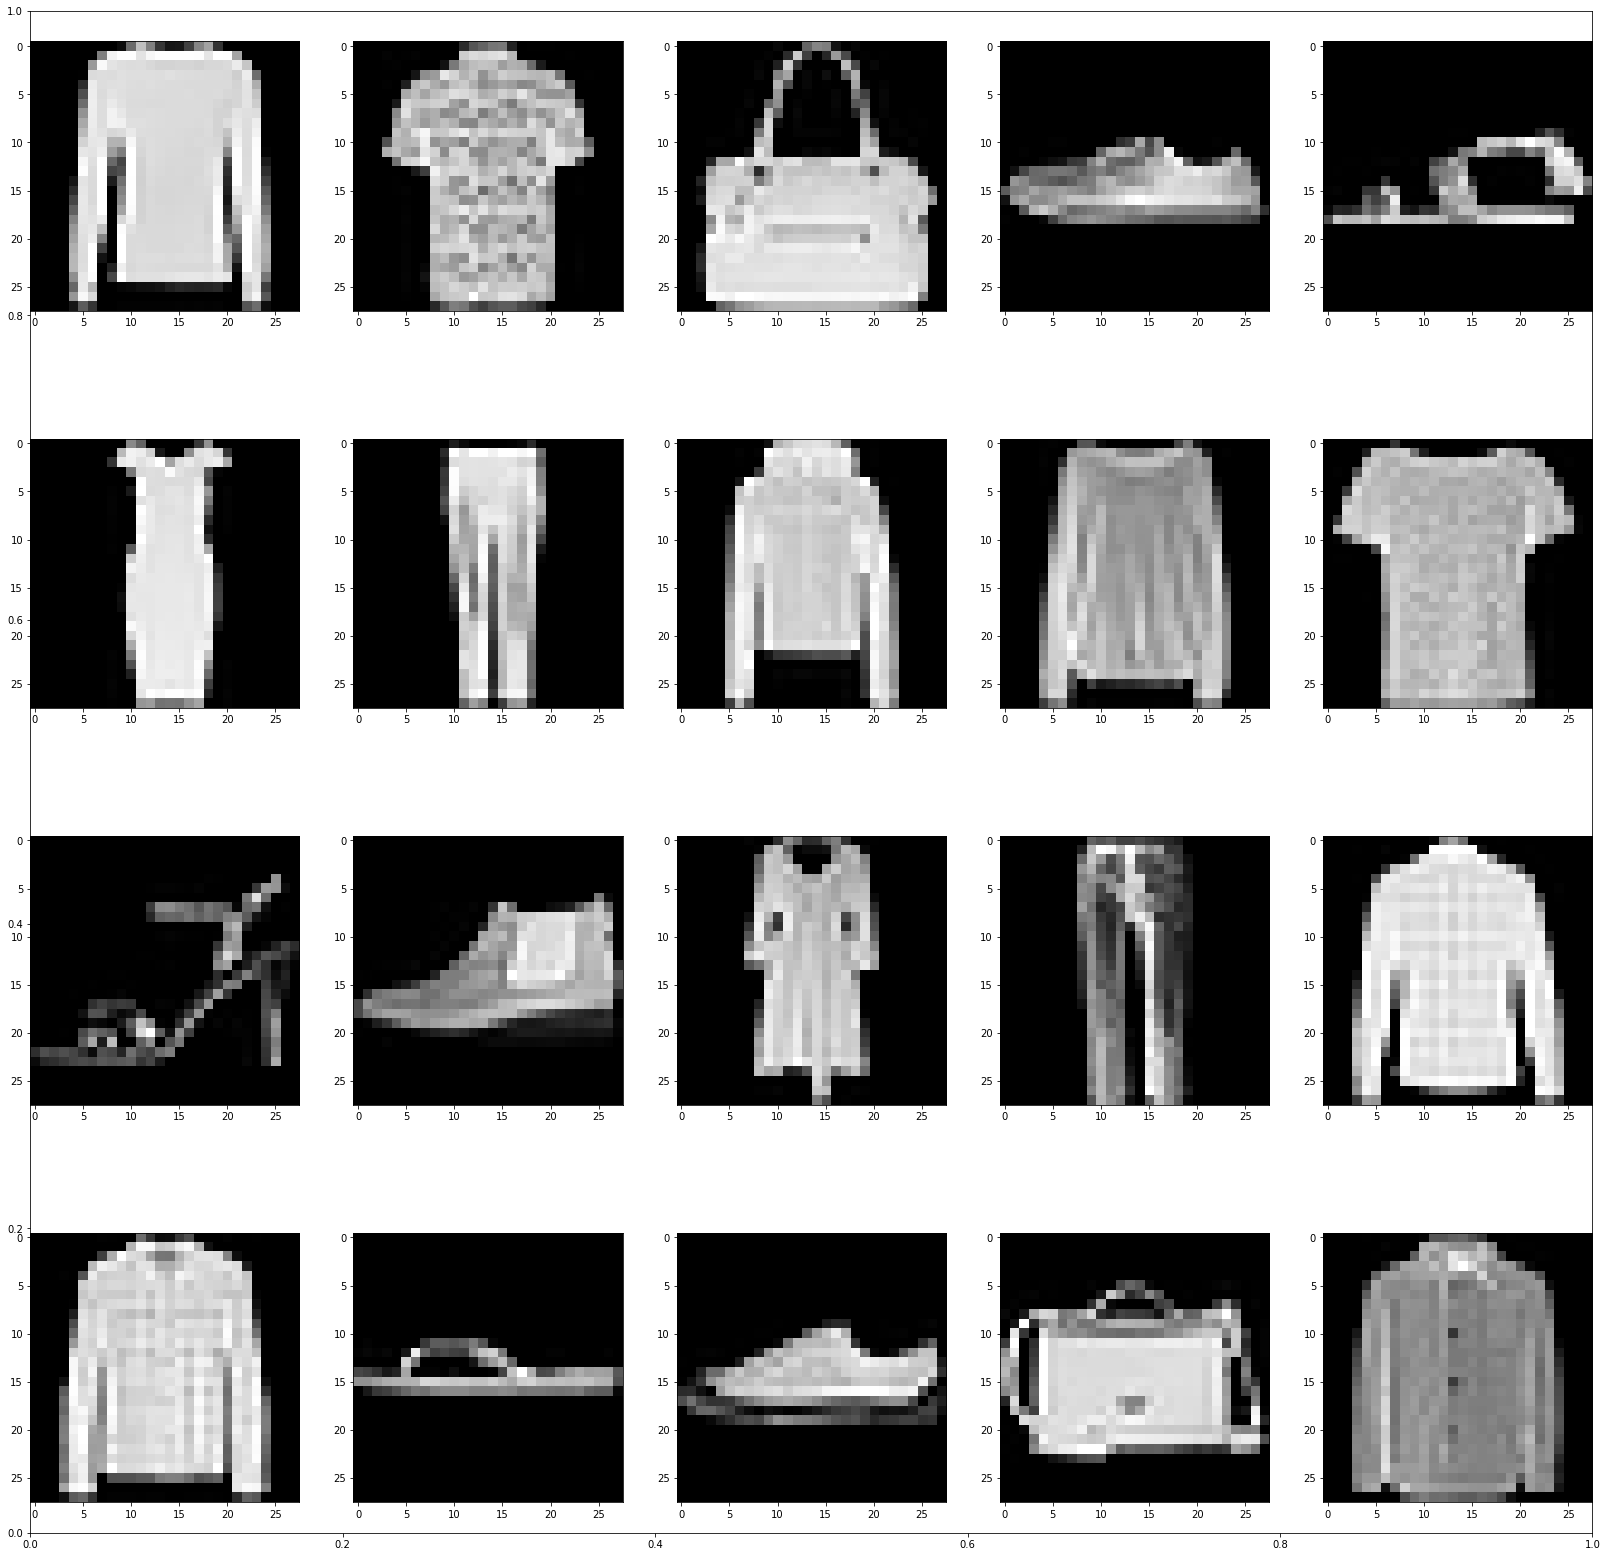

AE 30D


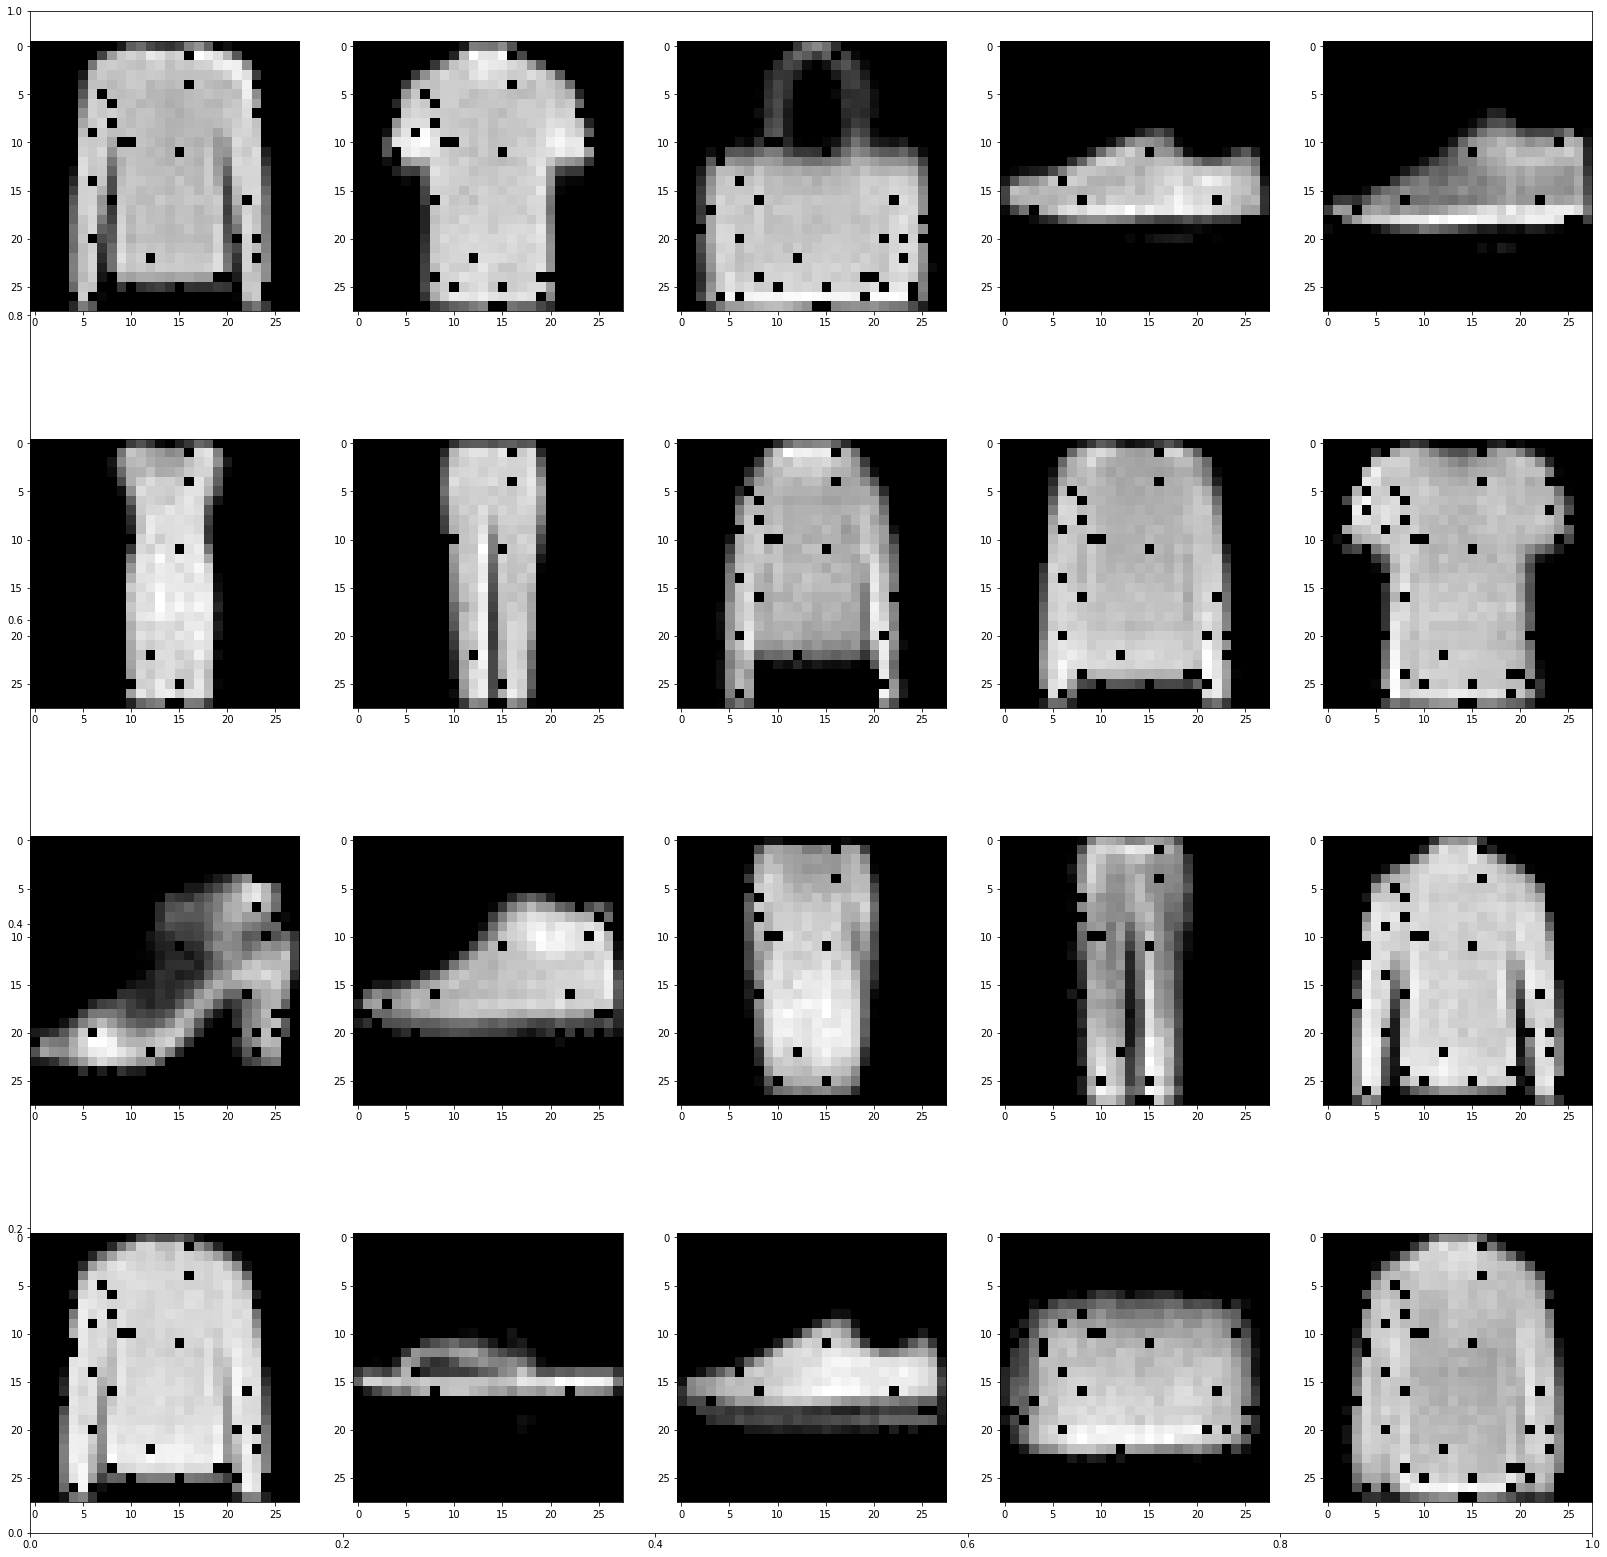

VAE 30D


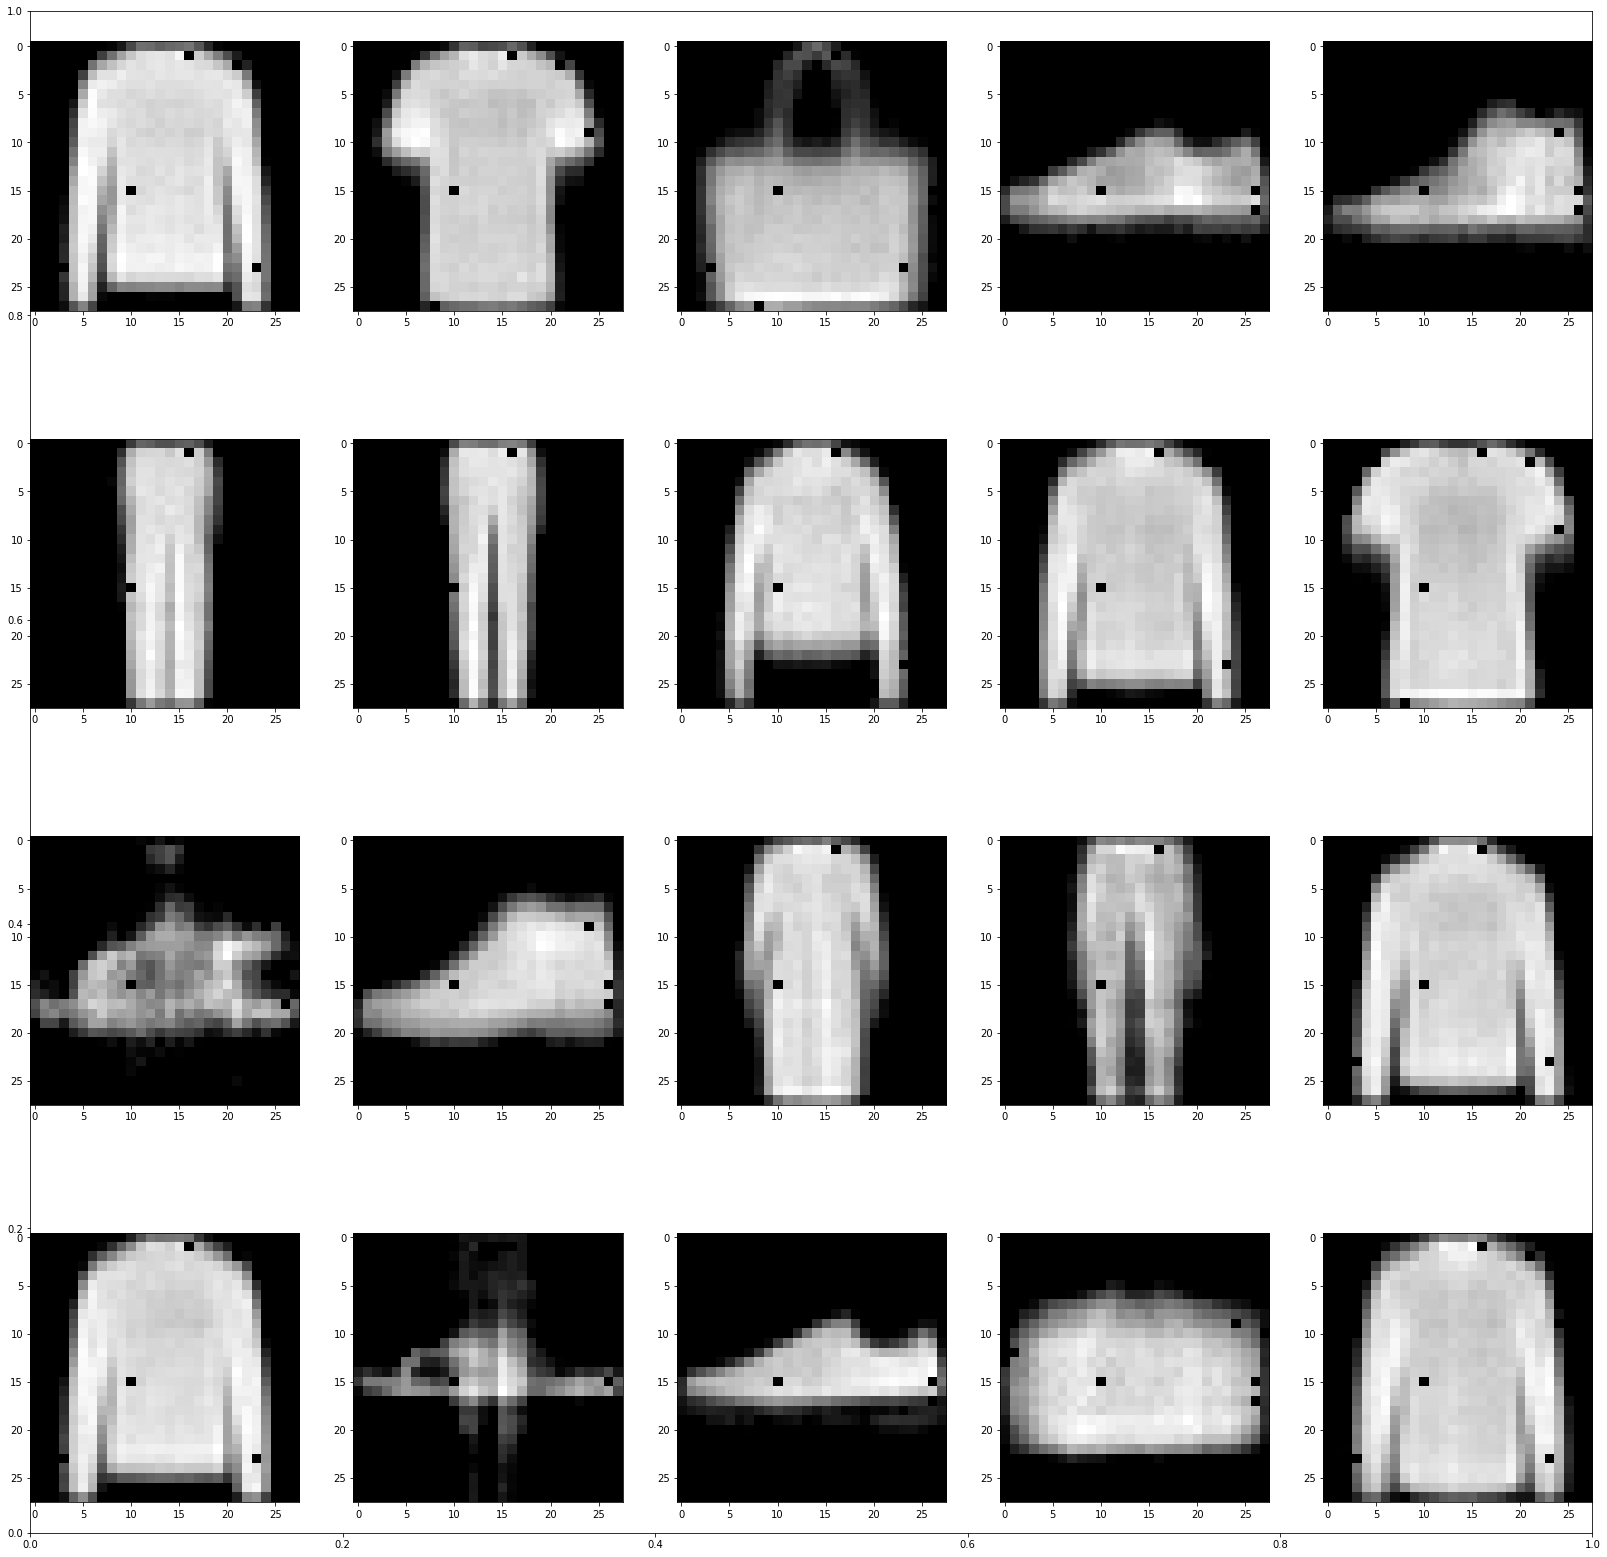

In [13]:
def plot_reconstructions(models, n):
    x = next(iter(test_loader))[0][:n]  # Get a batch and choose `n` of images
    print('Data')
    show(x.squeeze(1), 4)

    x = x.flatten(start_dim=1).to(device)
    for model in models:
        model.eval()
        x_hat, _, _ = model(x)
        print('%s %dD' % (model.type_str, model.z_dim))
        show(x_hat.detach().cpu(), rows=4)
models = [ae, vae]
plot_reconstructions(models, 20)

#interpolation part1
now we want to produce first image that has new features. there is probablity that these features even not exist in train dataset. in this part we want to find the mean of some trouser images in z space and then find mean of some shirt image in z space. then add this means together and give this new z to decoder. we expect that we have Tshirt that has trouser on it.
this is so usefull. consider some images of some faces. mean all the faces that has smile on theire faces and similar thing to all faces that has no smile. then subtract no smile mean in z space from smile faces in z-space. this work gives you the smile in z space. so you can add this smile to every face and make angry face to happy face !!

Data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


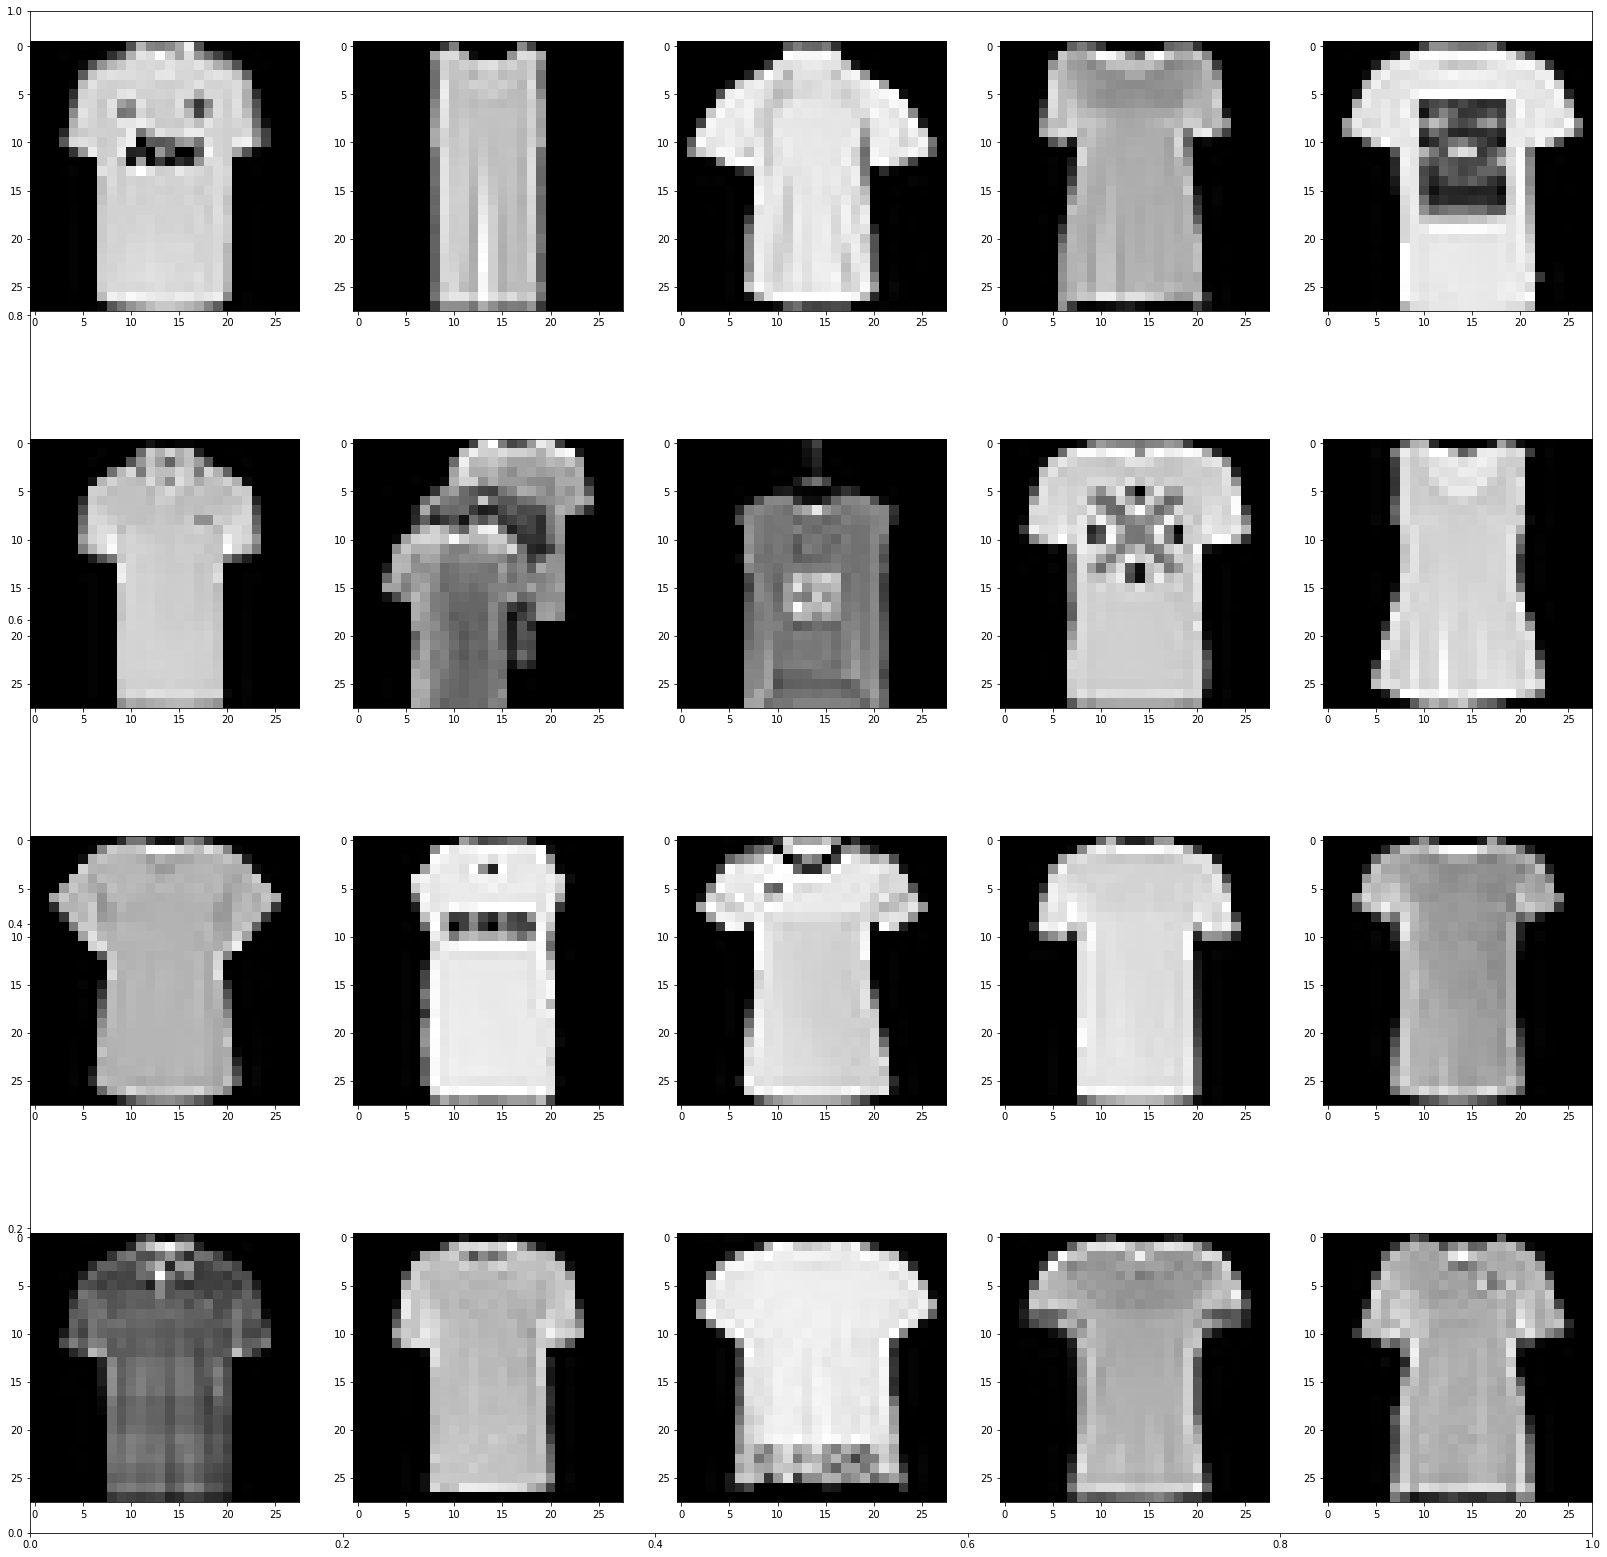

Data


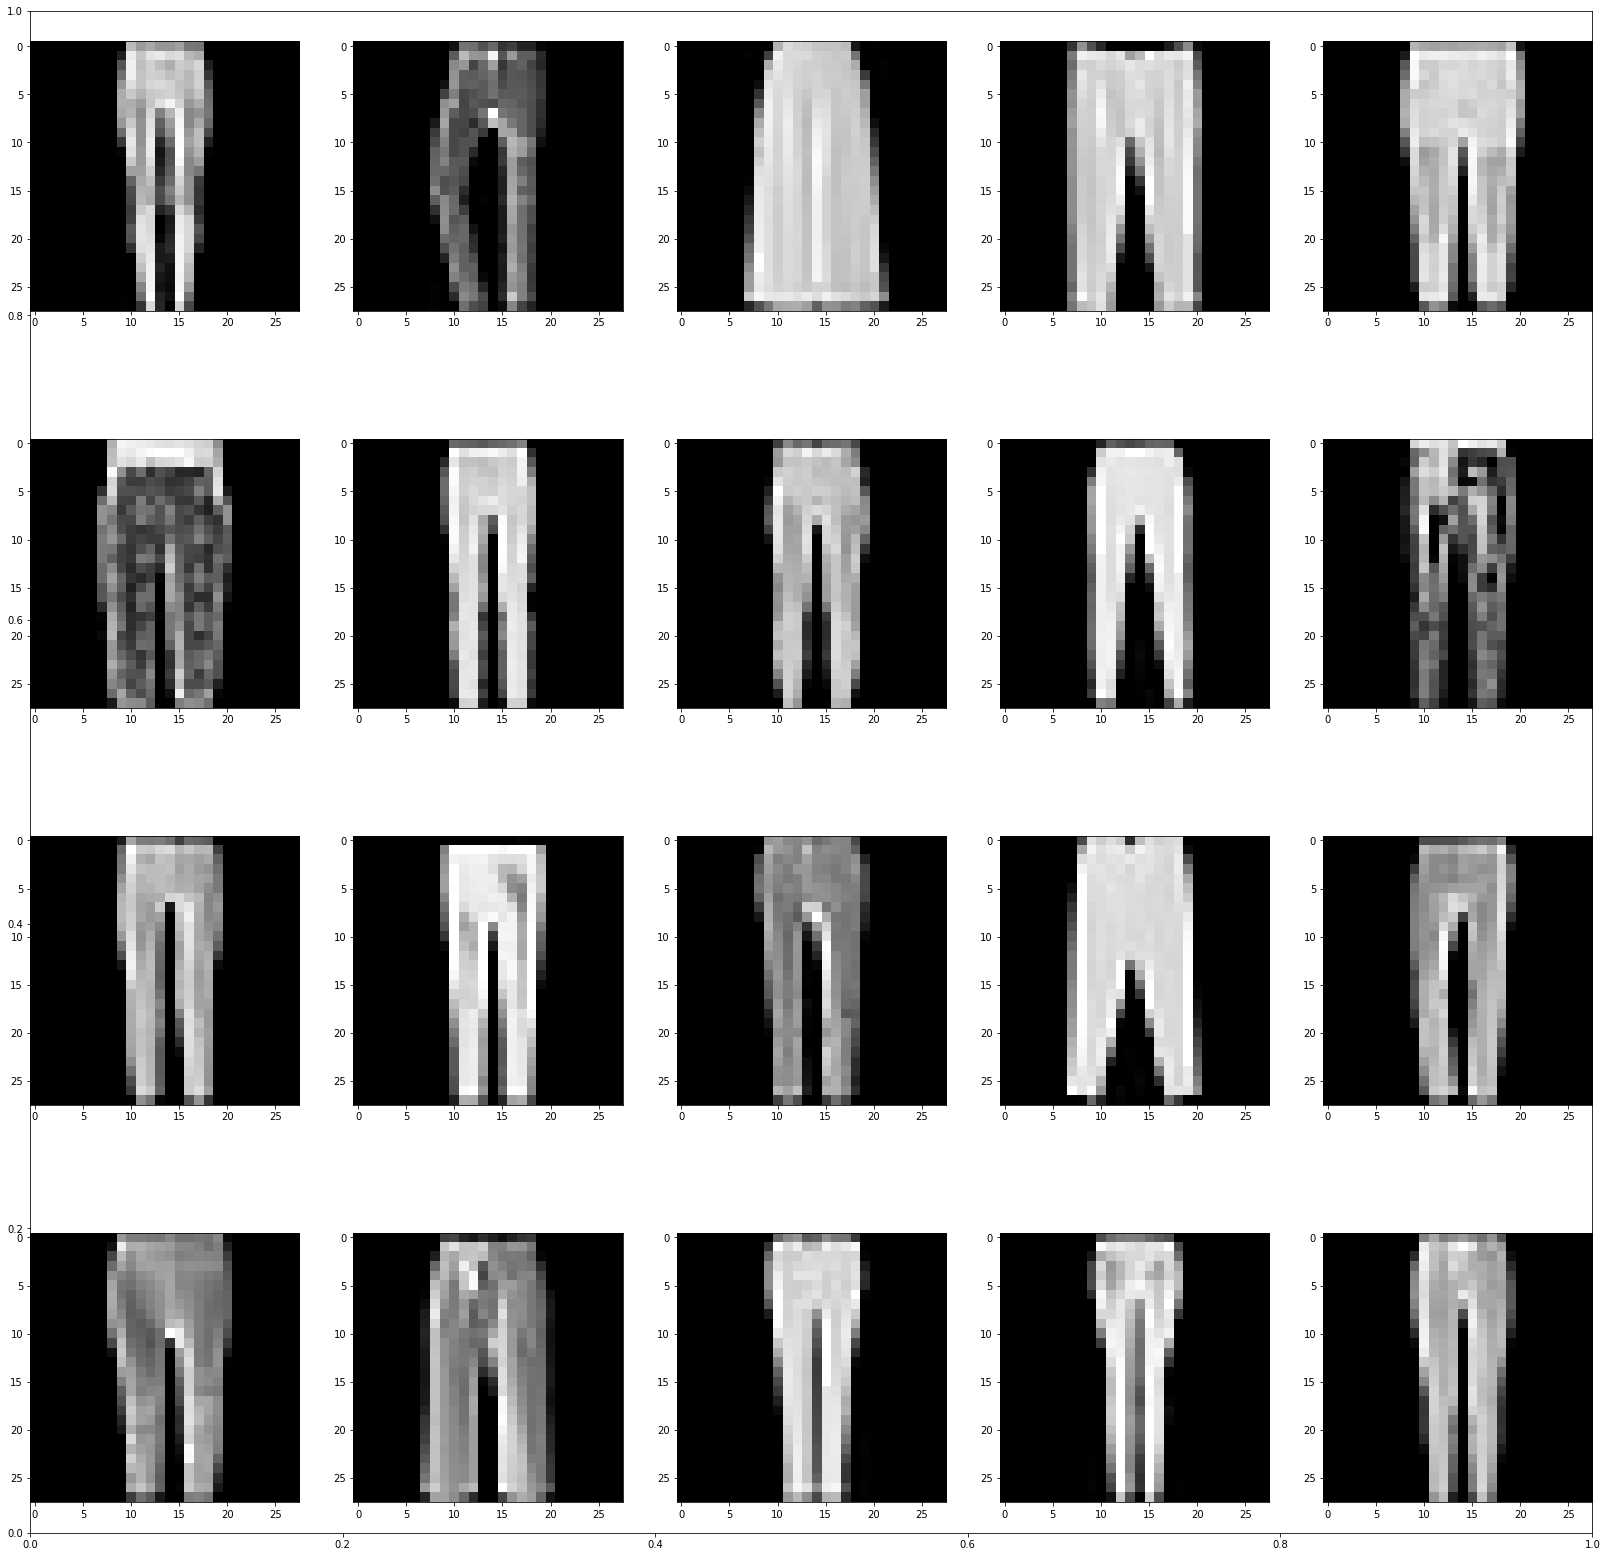

In [14]:
train_dataset = datasets.FashionMNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transforms.ToTensor())
idx = test_dataset.targets == 0
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]
test_loader_trouser = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)
x = next(iter(test_loader_trouser))[0][:20]  # Get a batch and choose `n` of images
print('Data')
show(x.squeeze(1), 4)

train_dataset = datasets.FashionMNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transforms.ToTensor())
idx = test_dataset.targets == 1
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]
test_loader_shirts = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)
x = next(iter(test_loader_shirts))[0][:20]  # Get a batch and choose `n` of images
print('Data')
show(x.squeeze(1), 4)

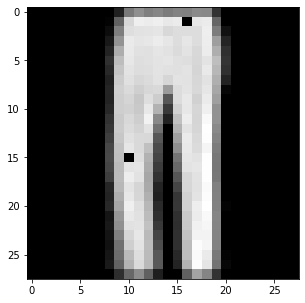

In [15]:
def combine(model, n_rows):
    """
    This function interpolates n_cols images between two random MNIST image
    """
    plt.rcParams['figure.figsize'] = (5, 5)
    x = next(iter(test_loader_trouser))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    y = next(iter(test_loader_shirts))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    shirt_with_trouser = None
    ########################## P15 ###############################
    # use x , y and find mean of trousers and Tshirts in z space #
    # then add theme together in z space and store this value    #
    # in shirt_with_trouser                                      #
    ########################## end ###############################
    model.eval()
    x_hat, x_mu, x_logvar = model(x)
    y_hat, y_mu, y_logvar = model(y)

    z_x = VAE.reparameterize(x_mu, x_logvar)
    z_y = VAE.reparameterize(y_mu, y_logvar)

    z_x = torch.mean(z_x, dim=0)
    z_y = torch.mean(z_y, dim=0)
    shirt_with_trouser = z_x + z_y
    ######################### end ##############################
    img = model.decoder(shirt_with_trouser).cpu().detach()
    img = img.reshape(-1, 28, 28)
    plt.imshow(img[0], cmap='gray')
vae = vae.to(device)
combine(vae, 128)

#interpolations part 2


AE 30D


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


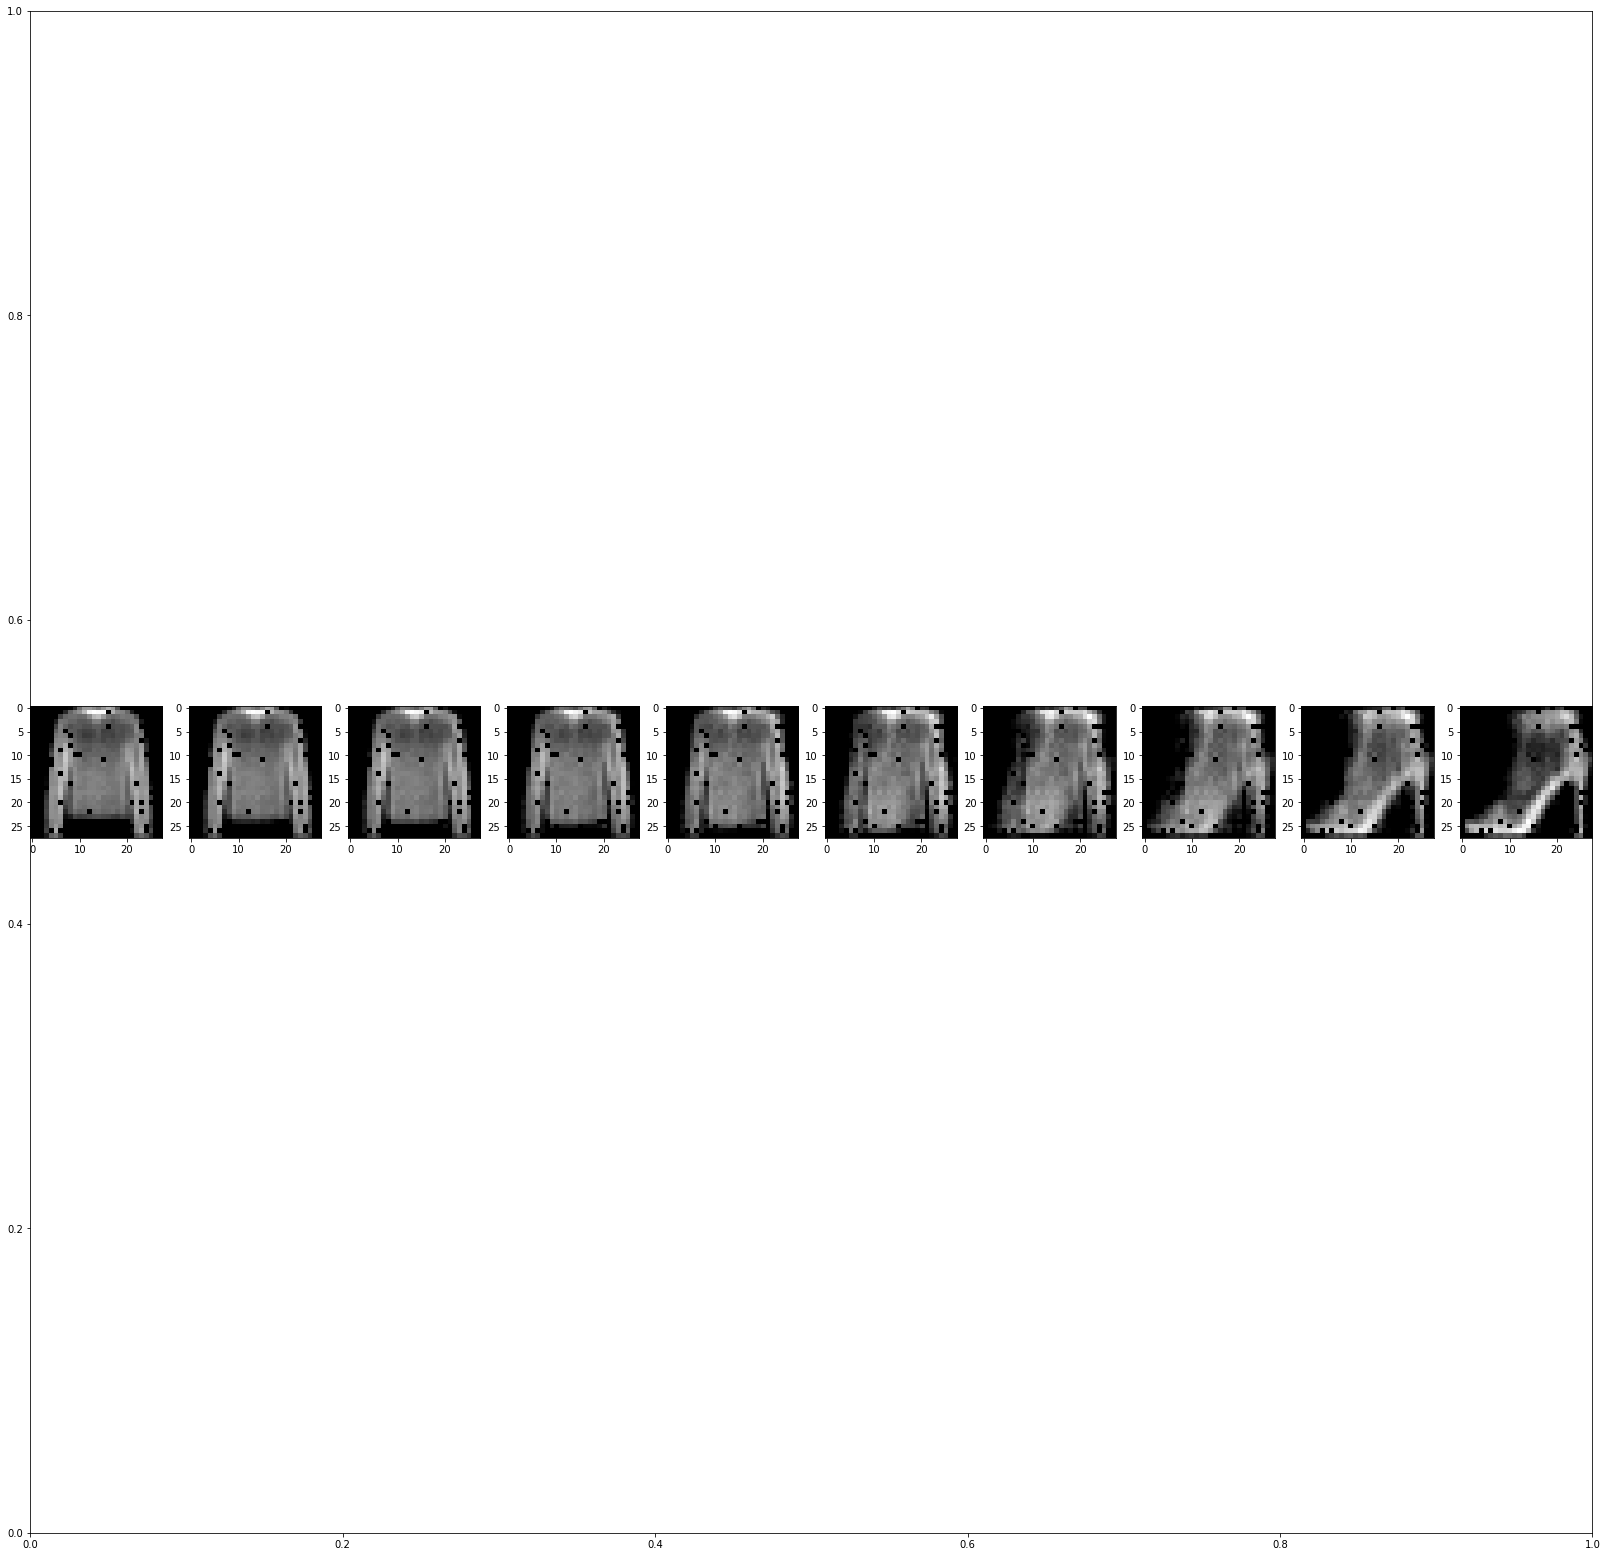

AE 30D


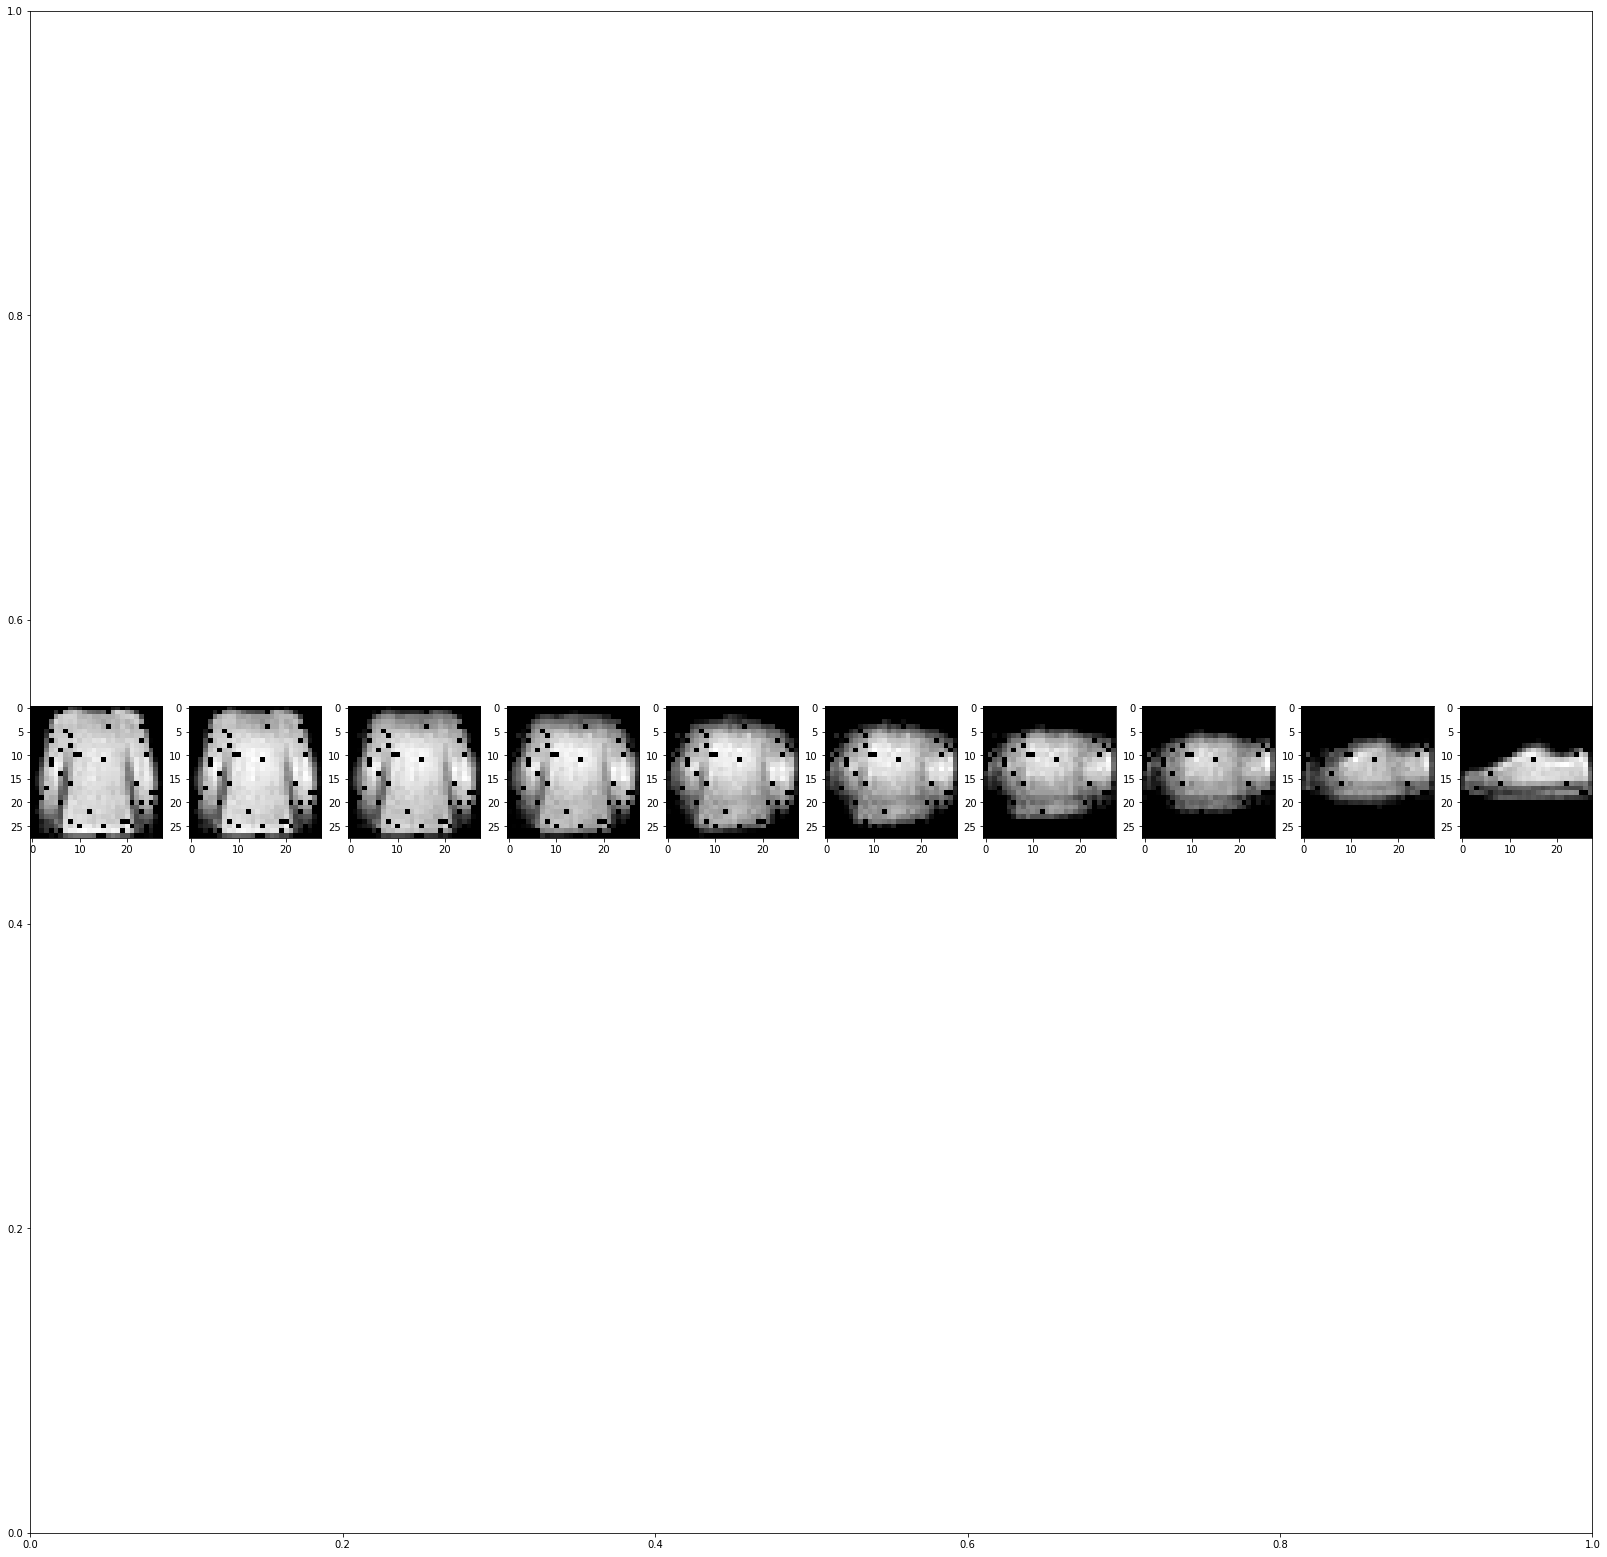

AE 30D


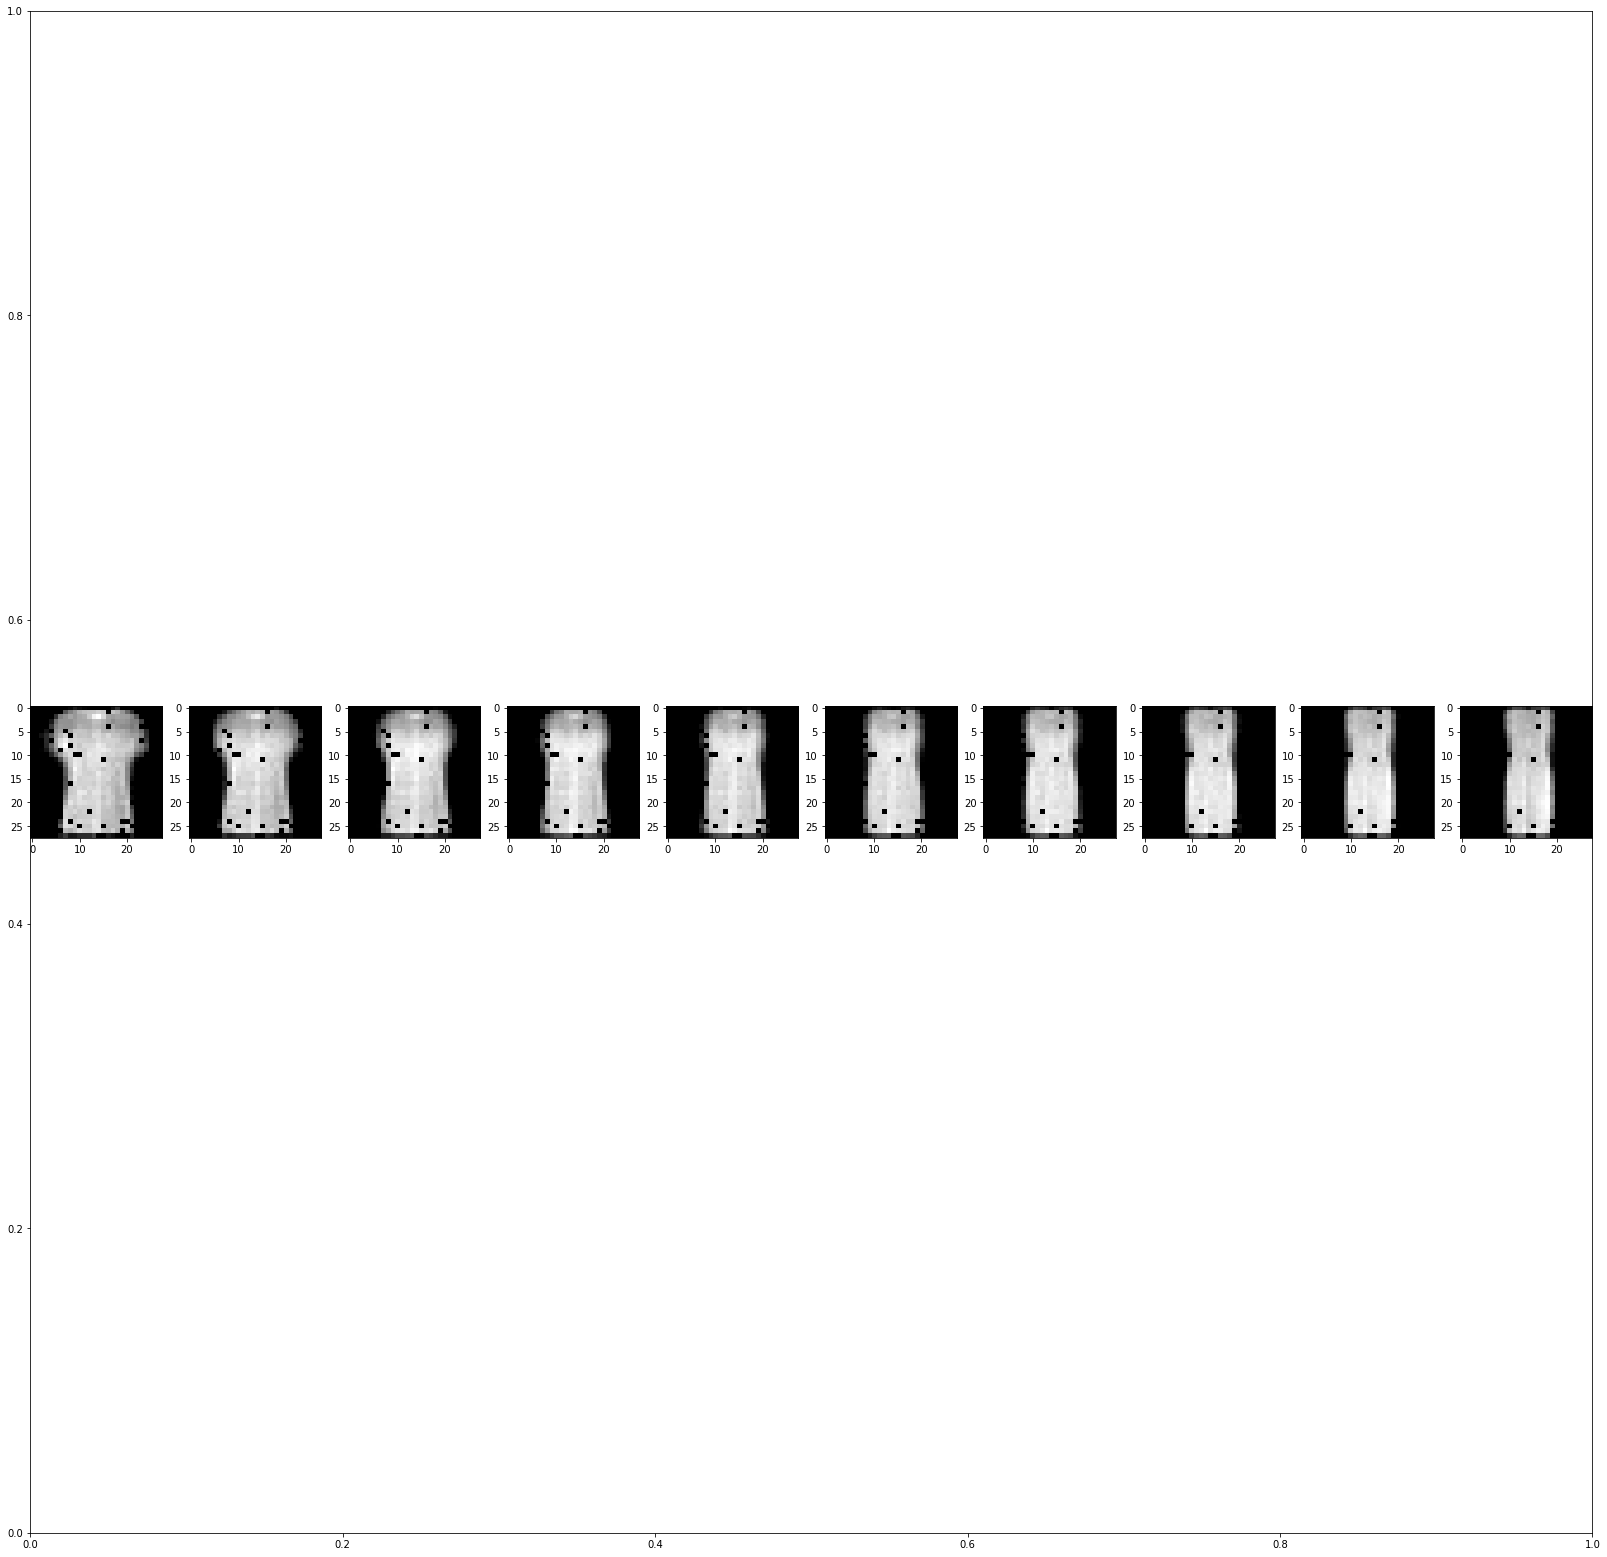

---

VAE 30D


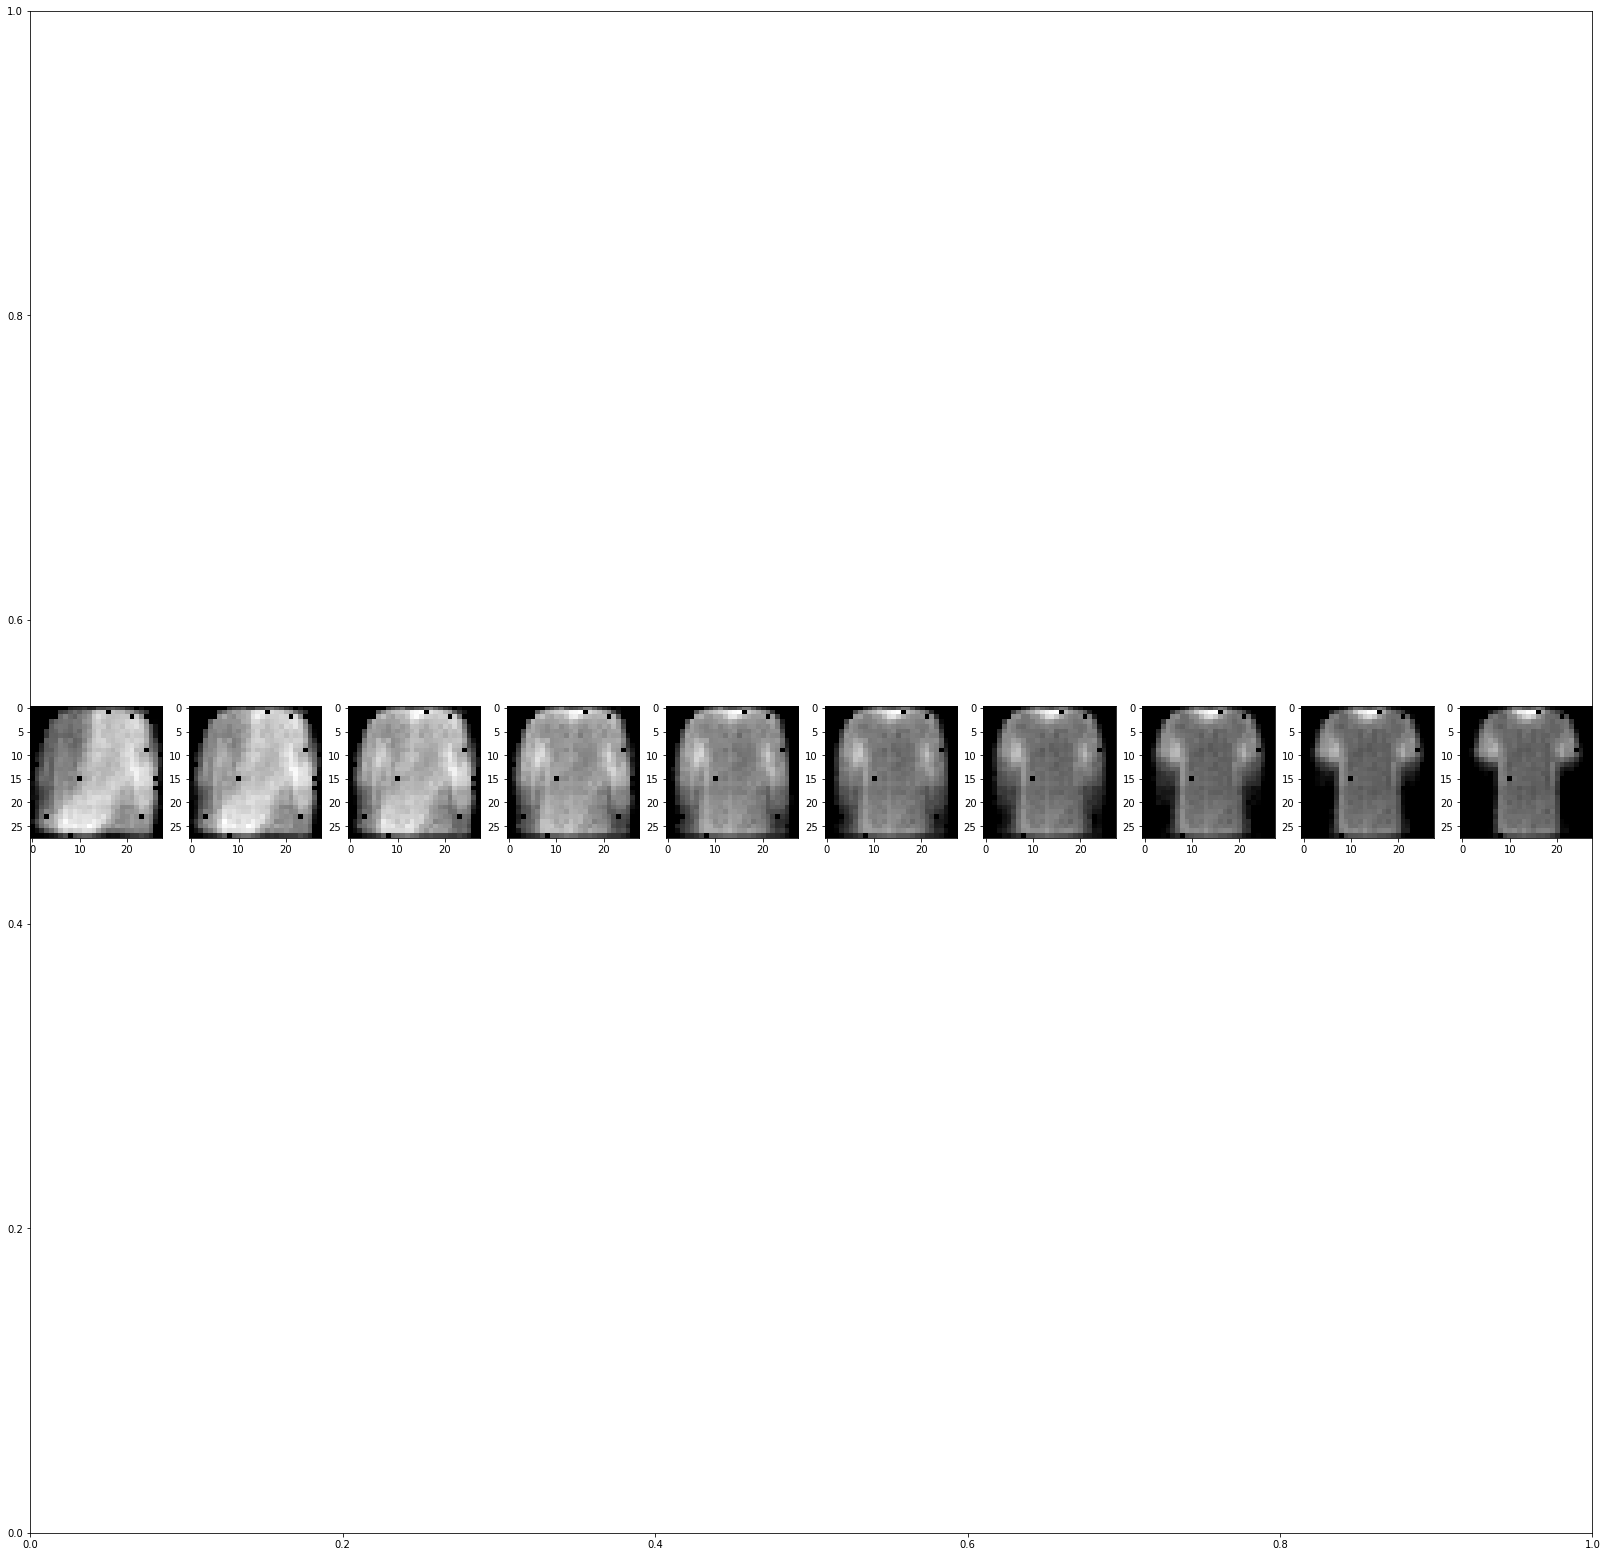

VAE 30D


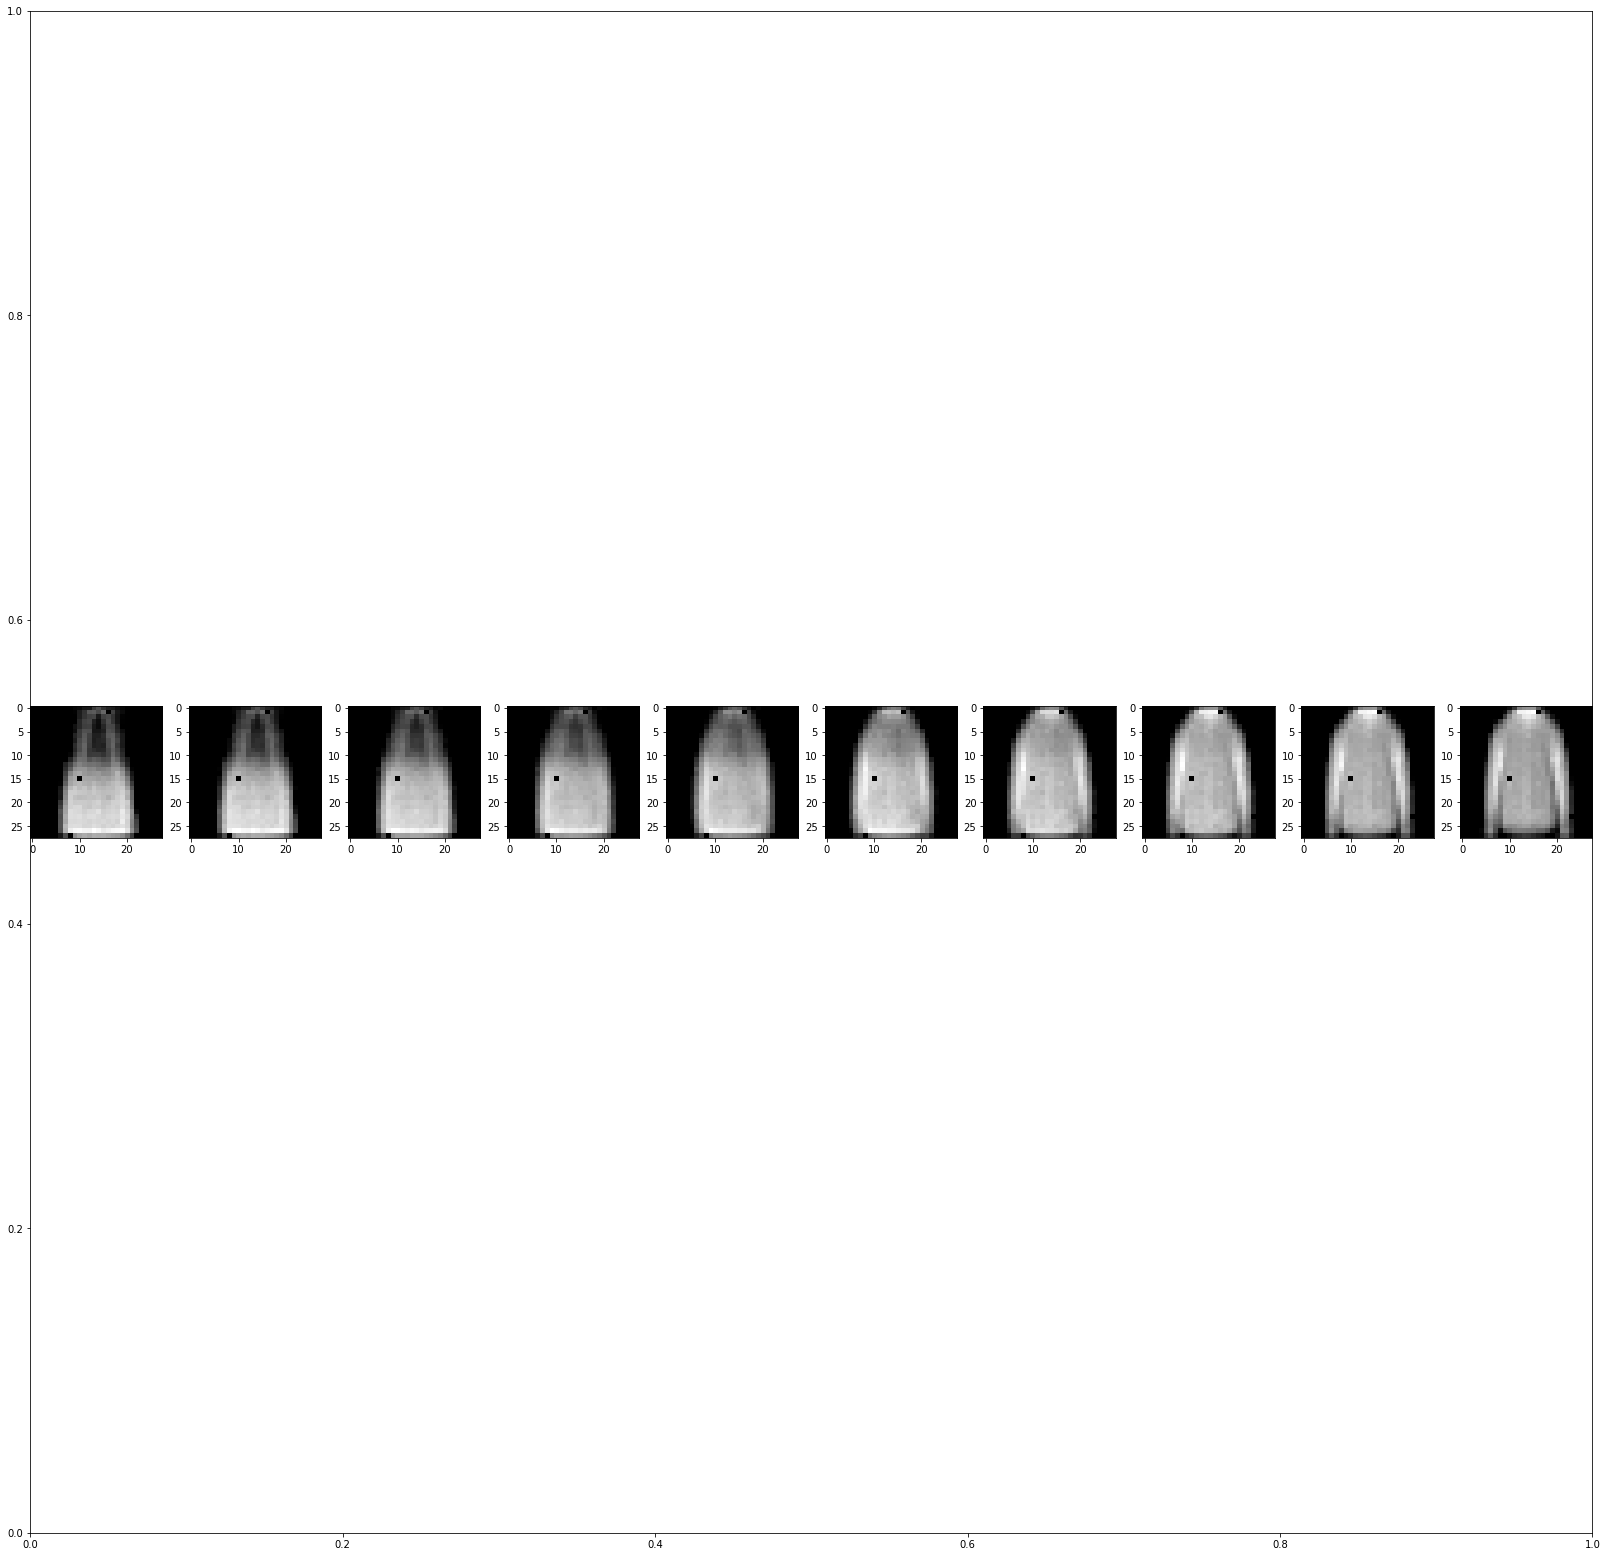

VAE 30D


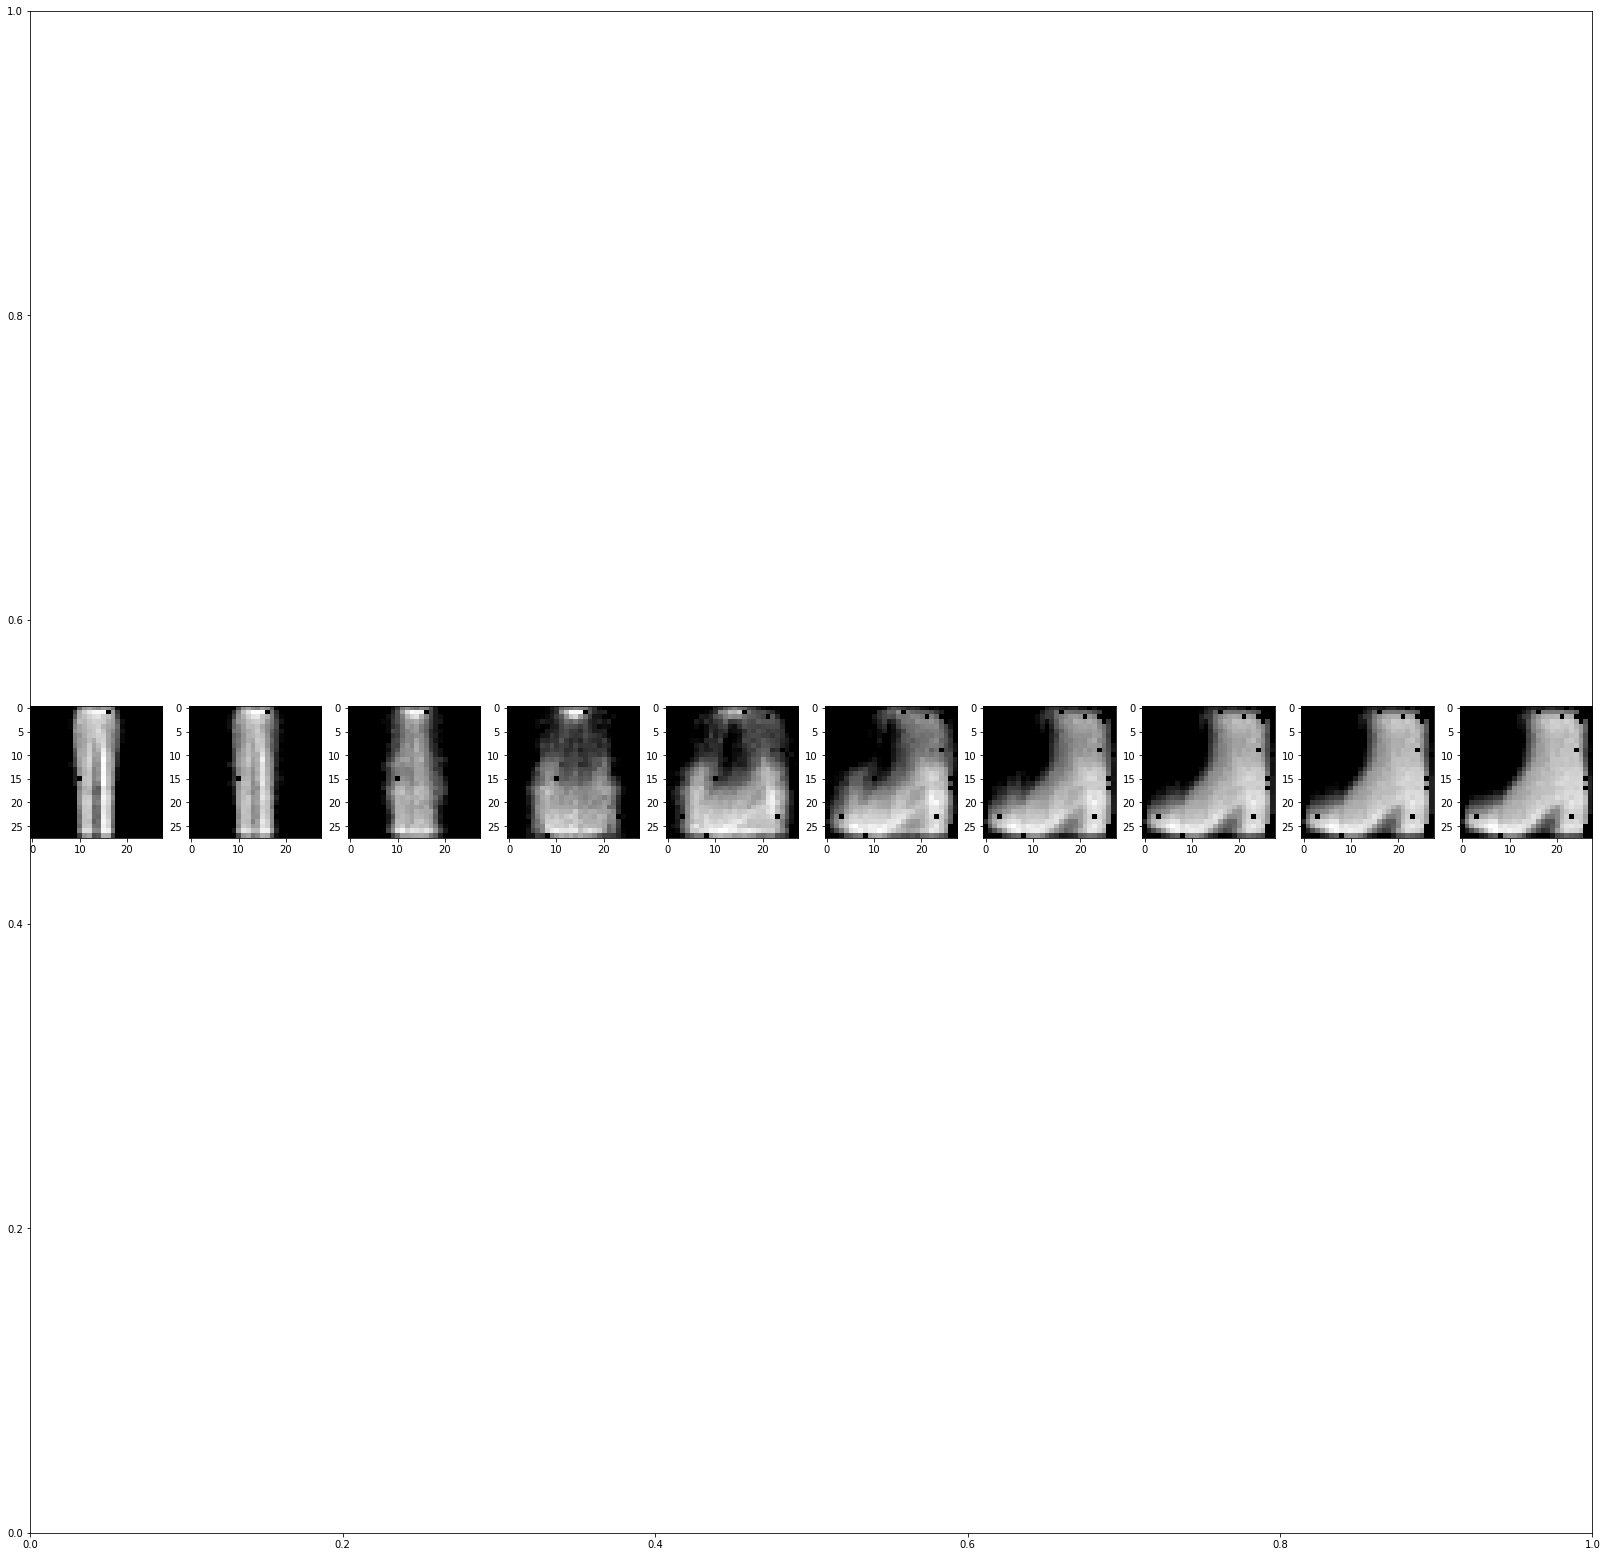

---



In [19]:
def plot_interpolations(model, n_rows, n_cols=10):
    """
    This function interpolates n_cols images between two random MNIST image
    """
    plt.rcParams['figure.figsize'] = (n_cols, n_rows)
    x = next(iter(test_loader))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    for i in range(n_rows):
        img1 = x[2 * i]
        img2 = x[2 * i + 1]
        model.eval()
        images = list()
        ################################ P16 #####################################
        # give your images(img1,img2) to model and get latent value for each     #
        # images.call them z1 and z2. then in z dimension space split the line   #
        # distance between z1 and z2,into n_cols and start to move from z1 to z2 #
        # and find n_cols point between z1 and z2 (in z_dim space). then use     #
        # decoder for new points in z_space and get new image for each point.    #
        # first append img1 to images list then append all new image that        #
        # decoders produced and then append img2 at the end of list.             #
        ##########################################################################
        img1_hat, img1_mu, img1_logvar = model(img1)
        img2_hat, img2_mu, img2_logvar = model(img2)
        if model.type_str == "AE":
          z_img1 = img1_mu
          z_img2 = img2_mu
        else:
          z_img1 = VAE.reparameterize(img1_mu, img1_logvar)
          z_img2 = VAE.reparameterize(img2_mu, img2_logvar)

        for j in range(n_cols):
          new_z = (z_img1 + (j+1)*(z_img2 - z_img1)/n_cols).float()
          images += [model.decoder(new_z).cpu().detach()]
        ################################ end #####################################
        images = torch.stack(images)
        print('%s %dD' % (model.type_str, model.z_dim))
        show(images)
    print('---\n')
plot_interpolations(ae, 3)
plot_interpolations(vae, 3)